## Iteration 1 - Ansatz 1: Anfänglicher Hybrid (einfacher Klassifikator + PCA + KMeans)

In [38]:
# Schritt 1 (erneut): CSV ohne parse_dates laden und fortfahren
# RAW-Vorschau des problematischen CSV – Zeilenweise einlesen für Diagnose
with open("/Users/svitlanakovalivska/variable_classifier_app/data/cnc_daten.csv", "r", encoding="utf-8") as file:
    zeilen = [next(file) for _ in range(10)]

# Rohvorschau der ersten 10 Zeilen (nicht geparst)
for i, zeile in enumerate(zeilen):
    print(f"Zeile {i+1}: {zeile.strip()}")


Zeile 1: name;time;/Axis/Settings/SPIND_MAX_VELO_G26;/Axis/Settings/SPIND_MAX_VELO_LIMS;/Axis/Settings/SPIND_MIN_VELO_G25;/Axis/Settings/WORKAREA_LIMIT_MINUS;/Axis/Settings/WORKAREA_LIMIT_PLUS;/Axis/Settings/WORKAREA_MINUS_ENABLE;/Axis/Settings/WORKAREA_PLUS_ENABLE;/Bag/State/opMode;/Bag/State/readyActive;/Bag/State/resetActive;/Channel/ChannelDiagnose/actCycleTimeBrut;/Channel/ChannelDiagnose/actCycleTimeNet;/Channel/ChannelDiagnose/aveCycleTimeNet;/Channel/ChannelDiagnose/cycleTime;/Channel/MachineAxis/measPos1;/Channel/MachineAxis/measPos2;/Nck/ChannelDiagnose/actCycleTimeBrut;/Nck/ChannelDiagnose/actCycleTimeNet;/Nck/ChannelDiagnose/actNckLoad;/Nck/ChannelDiagnose/aveCycleTimeNet;/Nck/ChannelDiagnose/aveNckLoad;/Nck/ChannelDiagnose/dpSlaveCfgOutputTime;/Nck/ChannelDiagnose/poweronTime;/Nck/ChannelDiagnose/setupTime;/Nck/ChannelDiagnose/sumCycleTimeNet;/Nck/ChannelDiagnose/taskCycleTime;/Nck/MachineAxis/aaAlarmStat;/Nck/MachineAxis/aaAxChangeStat;/Nck/MachineAxis/aaAxChangeTyp;/Nck/

In [39]:
# SCHRITT 2: Vorverarbeitung der Rohdaten
# ---------------------------------------
# Beschreibung: Wir lesen die CSV-Datei mit korrekt gesetztem Delimiter (;) und deutschem Dezimaltrennzeichen (Komma).
# Ziel: Zahlen korrekt als numerische Werte interpretieren, leere Felder zulassen.
import pandas as pd
# CSV mit ";" lesen und "," als Dezimalzeichen interpretieren
df_clean = pd.read_csv(
    "/Users/svitlanakovalivska/variable_classifier_app/data/cnc_daten.csv",
    sep=";",
    decimal=",",
    low_memory=False
)

# Überblick
print("Form der bereinigten Daten:", df_clean.shape)
print("Spaltenübersicht:")
print(df_clean.columns.tolist()[:10])  # Nur die ersten 10 Spalten zeigen
print("Beispielhafte Zeile:")
print(df_clean.iloc[1, :10])  # Nur ein Ausschnitt zeigen zur Übersicht


Form der bereinigten Daten: (6106, 34)
Spaltenübersicht:
['name', 'time', '/Axis/Settings/SPIND_MAX_VELO_G26', '/Axis/Settings/SPIND_MAX_VELO_LIMS', '/Axis/Settings/SPIND_MIN_VELO_G25', '/Axis/Settings/WORKAREA_LIMIT_MINUS', '/Axis/Settings/WORKAREA_LIMIT_PLUS', '/Axis/Settings/WORKAREA_MINUS_ENABLE', '/Axis/Settings/WORKAREA_PLUS_ENABLE', '/Bag/State/opMode']
Beispielhafte Zeile:
name                                                   CNC7
time                                    1749612305912309400
/Axis/Settings/SPIND_MAX_VELO_G26                       NaN
/Axis/Settings/SPIND_MAX_VELO_LIMS                      NaN
/Axis/Settings/SPIND_MIN_VELO_G25                       NaN
/Axis/Settings/WORKAREA_LIMIT_MINUS                     NaN
/Axis/Settings/WORKAREA_LIMIT_PLUS                      NaN
/Axis/Settings/WORKAREA_MINUS_ENABLE                    NaN
/Axis/Settings/WORKAREA_PLUS_ENABLE                     NaN
/Bag/State/opMode                                       NaN
Name: 1, dtype: 

In [40]:
import numpy as np

# SCHRITT 3: Statistische Kennzahlen berechnen
# --------------------------------------------
# Ziel: Für jede numerische Variable statistische Eigenschaften berechnen,
# die später für Klassifikation und Clustering verwendet werden.

# Liste der numerisch interpretierbaren Spalten (ohne 'name', 'time')
variablen = [col for col in df_clean.columns if col not in ["name", "time"]]

# Container für Ergebnisse
statistiken = []

for var in variablen:
    serie = pd.to_numeric(df_clean[var], errors='coerce')  # In Float umwandeln
    if serie.dropna().empty:
        continue  # Überspringen, wenn leer

    werte_ohne_na = serie.dropna()
    unique_vals = werte_ohne_na.unique()
    nunique = len(unique_vals)
    std = serie.std()
    mean = serie.mean()
    min_val = serie.min()
    max_val = serie.max()
    p5, p95 = np.percentile(werte_ohne_na, [5, 95])
    span = p95 - p5
    outlier_anteil = ((werte_ohne_na < p5) | (werte_ohne_na > p95)).sum() / len(werte_ohne_na)
    wechsel = (werte_ohne_na != werte_ohne_na.shift(1)).sum()
    extreme_count = ((serie == min_val) | (serie == max_val)).sum()
    monotonic = serie.is_monotonic_increasing

    statistiken.append({
        "Name": var,
        "Mittelwert": mean,
        "Standardabw": std,
        "Min": min_val,
        "Max": max_val,
        "Perzentil_5": p5,
        "Perzentil_95": p95,
        "Perzentil_Spanne": span,
        "Ausreißer-Anteil": outlier_anteil,
        "Anzahl Änderungen": wechsel,
        "Extremwertanteil": extreme_count / len(serie),
        "Monoton steigend": monotonic,
        "Anzahl eindeutig": nunique
    })

# In DataFrame umwandeln
stats_df = pd.DataFrame(statistiken)

# Ergebnis anzeigen (nur erste Zeilen)
print("Beispielhafte berechnete Statistik (erste 5 Variablen):")
print(stats_df.head())


Beispielhafte berechnete Statistik (erste 5 Variablen):
                                  Name   Mittelwert  Standardabw          Min  \
0    /Axis/Settings/SPIND_MAX_VELO_G26       1000.0          0.0       1000.0   
1   /Axis/Settings/SPIND_MAX_VELO_LIMS        100.0          0.0        100.0   
2    /Axis/Settings/SPIND_MIN_VELO_G25          0.0          0.0          0.0   
3  /Axis/Settings/WORKAREA_LIMIT_MINUS -100000000.0          0.0 -100000000.0   
4   /Axis/Settings/WORKAREA_LIMIT_PLUS  100000000.0          0.0  100000000.0   

           Max  Perzentil_5  Perzentil_95  Perzentil_Spanne  Ausreißer-Anteil  \
0       1000.0       1000.0        1000.0               0.0               0.0   
1        100.0        100.0         100.0               0.0               0.0   
2          0.0          0.0           0.0               0.0               0.0   
3 -100000000.0 -100000000.0  -100000000.0               0.0               0.0   
4  100000000.0  100000000.0   100000000.0           

In [41]:
stats_df

,Name,Mittelwert,Standardabw,Min,Max,Perzentil_5,Perzentil_95,Perzentil_Spanne,Ausreißer-Anteil,Anzahl Änderungen,Extremwertanteil,Monoton steigend,Anzahl eindeutig
0,/Axis/Settings/SPIND_MAX_VELO_G26,1.000000e+03,0.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,0.000000,0.000000,1,0.000328,False,1
1,/Axis/Settings/SPIND_MAX_VELO_LIMS,1.000000e+02,0.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,0.000000,0.000000,1,0.000328,False,1
2,/Axis/Settings/SPIND_MIN_VELO_G25,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1,0.000328,False,1
3,/Axis/Settings/WORKAREA_LIMIT_MINUS,-1.000000e+08,0.000000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,0.000000,0.000000,1,0.000328,False,1
4,/Axis/Settings/WORKAREA_LIMIT_PLUS,1.000000e+08,0.000000,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,0.000000,0.000000,1,0.000328,False,1
5,/Axis/Settings/WORKAREA_MINUS_ENABLE,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1
6,/Axis/Settings/WORKAREA_PLUS_ENABLE,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1
7,/Bag/State/opMode,1.000000e+00,1.095445,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,2.000000,0.000000,6,0.000983,False,2
8,/Bag/State/readyActive,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1
9,/Bag/State/resetActive,4.915254e-01,0.504219,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000,0.000000,59,0.009663,False,2


Ergebnis dieses Schrittes (Schritt 3 – Statistische Kennzahlen berechnen):

Wir haben pro Variable berechnet:

Mittelwert, Standardabweichung, Min/Max
und 95. Perzentil und deren Spanne
Anteil an Ausreißern (außerhalb der Perzentile)
Anzahl Zustandsänderungen
Anteil Extremwerte
Monotonie und Anzahl eindeutiger Werte

Diese Kennzahlen sind Basis für die regelbasierte Klassifikation im nächsten Schritt.

In [42]:
# SCHRITT 4: Regelbasierte Klassifikation auf Basis von Kennzahlen
# ----------------------------------------------------------------
# Ziel: Basierend auf den berechneten Metriken ordnen wir jeder Variable eine Kategorie zu.
# Logik gemäß Konzept (Dokument): z. B. leer, konstant, boolean, rauschsignal, zähler, sensorwert etc.

def regelbasierte_klassifikation(zeile):
    if zeile["Anzahl eindeutig"] == 0:
        return "leer"
    elif zeile["Anzahl eindeutig"] == 1:
        return "konstant"
    elif zeile["Anzahl eindeutig"] <= 2 and zeile["Min"] in [0, 1] and zeile["Max"] in [0, 1]:
        return "boolean"
    elif zeile["Standardabw"] < 0.01 or zeile["Perzentil_Spanne"] < 0.05:
        return "rauschsignal"
    elif zeile["Anzahl Änderungen"] < 10:
        return "status"
    elif zeile["Monoton steigend"]:
        return "zähler"
    elif zeile["Ausreißer-Anteil"] > 0.1:
        return "instabil"
    elif zeile["Extremwertanteil"] > 0.2:
        return "grenzwertbasiert"
    elif zeile["Standardabw"] > 0.01 and zeile["Anzahl Änderungen"] >= 10:
        return "sensorwert"
    else:
        return "unbekannt"

# Kategorie zuweisen
stats_df["Kategorie"] = stats_df.apply(regelbasierte_klassifikation, axis=1)

# Vorschau anzeigen
print("Regelbasiertes Klassifikationsergebnis (erste 5 Zeilen):")
print(stats_df[["Name", "Kategorie"]].head())


Regelbasiertes Klassifikationsergebnis (erste 5 Zeilen):
                                  Name Kategorie
0    /Axis/Settings/SPIND_MAX_VELO_G26  konstant
1   /Axis/Settings/SPIND_MAX_VELO_LIMS  konstant
2    /Axis/Settings/SPIND_MIN_VELO_G25  konstant
3  /Axis/Settings/WORKAREA_LIMIT_MINUS  konstant
4   /Axis/Settings/WORKAREA_LIMIT_PLUS  konstant


In [43]:
stats_df

,Name,Mittelwert,Standardabw,Min,Max,Perzentil_5,Perzentil_95,Perzentil_Spanne,Ausreißer-Anteil,Anzahl Änderungen,Extremwertanteil,Monoton steigend,Anzahl eindeutig,Kategorie
0,/Axis/Settings/SPIND_MAX_VELO_G26,1.000000e+03,0.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,0.000000,0.000000,1,0.000328,False,1,konstant
1,/Axis/Settings/SPIND_MAX_VELO_LIMS,1.000000e+02,0.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,0.000000,0.000000,1,0.000328,False,1,konstant
2,/Axis/Settings/SPIND_MIN_VELO_G25,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1,0.000328,False,1,konstant
3,/Axis/Settings/WORKAREA_LIMIT_MINUS,-1.000000e+08,0.000000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,0.000000,0.000000,1,0.000328,False,1,konstant
4,/Axis/Settings/WORKAREA_LIMIT_PLUS,1.000000e+08,0.000000,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,0.000000,0.000000,1,0.000328,False,1,konstant
5,/Axis/Settings/WORKAREA_MINUS_ENABLE,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1,konstant
6,/Axis/Settings/WORKAREA_PLUS_ENABLE,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1,konstant
7,/Bag/State/opMode,1.000000e+00,1.095445,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,2.000000,0.000000,6,0.000983,False,2,status
8,/Bag/State/readyActive,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,1,0.000328,False,1,konstant
9,/Bag/State/resetActive,4.915254e-01,0.504219,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000,0.000000,59,0.009663,False,2,boolean


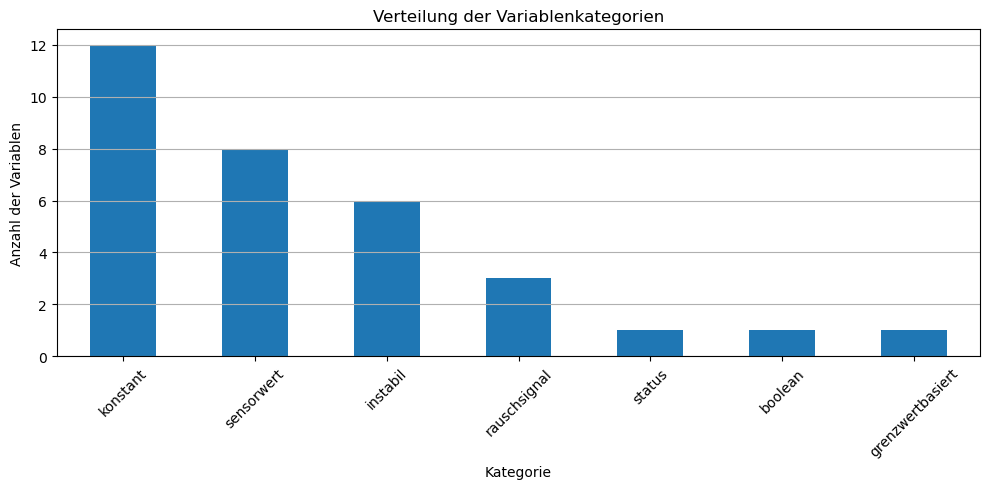

In [44]:
import matplotlib.pyplot as plt

# SCHRITT 5: Visualisierung der Kategorien
# ----------------------------------------
# Ziel: Übersichtliche Darstellung, wie viele Variablen in welche Kategorien eingeteilt wurden.
# Darstellung: Balkendiagramm

# Kategorien zählen
kategorie_counts = stats_df["Kategorie"].value_counts()

# Balkendiagramm erzeugen
plt.figure(figsize=(10, 5))
kategorie_counts.plot(kind="bar")
plt.title("Verteilung der Variablenkategorien")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl der Variablen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()


In [45]:
from sklearn.preprocessing import StandardScaler

# SCHRITT 6: Feature-Vektoren normalisieren für Clustering
# ---------------------------------------------------------
# Ziel: Alle relevanten Metriken standardisieren und als numerischen Vektor je Variable vorbereiten.

# Auswahl numerischer Features für Clustering
merkmale = [
    "Mittelwert", "Standardabw", "Perzentil_Spanne",
    "Ausreißer-Anteil", "Anzahl Änderungen", "Extremwertanteil"
]

# Skalierung (Standardisierung)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stats_df[merkmale])

# Ergebnis als DataFrame speichern
feature_df = pd.DataFrame(X_scaled, columns=[f"{m}_norm" for m in merkmale])
feature_df["Name"] = stats_df["Name"].values
feature_df["Kategorie"] = stats_df["Kategorie"].values

# Vorschau
print("Standardisierte Feature-Vektoren (erste 5 Zeilen):")
print(feature_df.head())


Standardisierte Feature-Vektoren (erste 5 Zeilen):
   Mittelwert_norm  Standardabw_norm  Perzentil_Spanne_norm  \
0        -0.002210         -0.446343              -0.445111   
1        -0.002246         -0.446343              -0.445111   
2        -0.002250         -0.446343              -0.445111   
3        -4.001935         -0.446343              -0.445111   
4         3.997436         -0.446343              -0.445111   

   Ausreißer-Anteil_norm  Anzahl Änderungen_norm  Extremwertanteil_norm  \
0              -0.911281               -0.804128              -0.287476   
1              -0.911281               -0.804128              -0.287476   
2              -0.911281               -0.804128              -0.287476   
3              -0.911281               -0.804128              -0.287476   
4              -0.911281               -0.804128              -0.287476   

                                  Name Kategorie  
0    /Axis/Settings/SPIND_MAX_VELO_G26  konstant  
1   /Axis/Setting

In [46]:
feature_df

,Mittelwert_norm,Standardabw_norm,Perzentil_Spanne_norm,Ausreißer-Anteil_norm,Anzahl Änderungen_norm,Extremwertanteil_norm,Name,Kategorie
0,-0.002210,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_G26,konstant
1,-0.002246,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_LIMS,konstant
2,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MIN_VELO_G25,konstant
3,-4.001935,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_MINUS,konstant
4,3.997436,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_PLUS,konstant
5,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_MINUS_ENABLE,konstant
6,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_PLUS_ENABLE,konstant
7,-0.002250,-0.443347,-0.443215,-0.911281,-0.800630,-0.274947,/Bag/State/opMode,status
8,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Bag/State/readyActive,konstant
9,-0.002250,-0.444964,-0.444163,-0.911281,-0.763548,-0.108941,/Bag/State/resetActive,boolean


In [47]:
from sklearn.cluster import KMeans

# SCHRITT 7: Clustering mit K-Means
# ----------------------------------
# Ziel: Gruppierung der Variablen basierend auf ähnlichem Verhalten (Feature-Vektor)
# Methode: KMeans mit n_clusters=5 (als Startpunkt)

# Nur normierte Features für Clustering verwenden
X_features = feature_df[[col for col in feature_df.columns if col.endswith("_norm")]].values

# KMeans-Clustering anwenden
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_features)

# Cluster-Label speichern
feature_df["Cluster"] = cluster_labels

# Ergebnis anzeigen
print("Beispielhafte Zuordnung zu Clustern (erste 5 Variablen):")
print(feature_df[["Name", "Kategorie", "Cluster"]].head())


Beispielhafte Zuordnung zu Clustern (erste 5 Variablen):
                                  Name Kategorie  Cluster
0    /Axis/Settings/SPIND_MAX_VELO_G26  konstant        2
1   /Axis/Settings/SPIND_MAX_VELO_LIMS  konstant        2
2    /Axis/Settings/SPIND_MIN_VELO_G25  konstant        2
3  /Axis/Settings/WORKAREA_LIMIT_MINUS  konstant        4
4   /Axis/Settings/WORKAREA_LIMIT_PLUS  konstant        2


In [48]:
feature_df

,Mittelwert_norm,Standardabw_norm,Perzentil_Spanne_norm,Ausreißer-Anteil_norm,Anzahl Änderungen_norm,Extremwertanteil_norm,Name,Kategorie,Cluster
0,-0.002210,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_G26,konstant,2
1,-0.002246,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_LIMS,konstant,2
2,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MIN_VELO_G25,konstant,2
3,-4.001935,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_MINUS,konstant,4
4,3.997436,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_PLUS,konstant,2
5,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_MINUS_ENABLE,konstant,2
6,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_PLUS_ENABLE,konstant,2
7,-0.002250,-0.443347,-0.443215,-0.911281,-0.800630,-0.274947,/Bag/State/opMode,status,2
8,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Bag/State/readyActive,konstant,2
9,-0.002250,-0.444964,-0.444163,-0.911281,-0.763548,-0.108941,/Bag/State/resetActive,boolean,2


In [49]:
# KMeans erneut mit numerischem n_init (Kompatibilität)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_features)

# Cluster-Label speichern
feature_df["Cluster"] = cluster_labels

# Ergebnis anzeigen
print("Beispielhafte Zuordnung zu Clustern (erste 5 Variablen):")
print(feature_df[["Name", "Kategorie", "Cluster"]].head())


Beispielhafte Zuordnung zu Clustern (erste 5 Variablen):
                                  Name Kategorie  Cluster
0    /Axis/Settings/SPIND_MAX_VELO_G26  konstant        2
1   /Axis/Settings/SPIND_MAX_VELO_LIMS  konstant        2
2    /Axis/Settings/SPIND_MIN_VELO_G25  konstant        2
3  /Axis/Settings/WORKAREA_LIMIT_MINUS  konstant        4
4   /Axis/Settings/WORKAREA_LIMIT_PLUS  konstant        2


In [50]:
feature_df

,Mittelwert_norm,Standardabw_norm,Perzentil_Spanne_norm,Ausreißer-Anteil_norm,Anzahl Änderungen_norm,Extremwertanteil_norm,Name,Kategorie,Cluster
0,-0.002210,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_G26,konstant,2
1,-0.002246,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MAX_VELO_LIMS,konstant,2
2,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/SPIND_MIN_VELO_G25,konstant,2
3,-4.001935,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_MINUS,konstant,4
4,3.997436,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_LIMIT_PLUS,konstant,2
5,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_MINUS_ENABLE,konstant,2
6,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Axis/Settings/WORKAREA_PLUS_ENABLE,konstant,2
7,-0.002250,-0.443347,-0.443215,-0.911281,-0.800630,-0.274947,/Bag/State/opMode,status,2
8,-0.002250,-0.446343,-0.445111,-0.911281,-0.804128,-0.287476,/Bag/State/readyActive,konstant,2
9,-0.002250,-0.444964,-0.444163,-0.911281,-0.763548,-0.108941,/Bag/State/resetActive,boolean,2


In [51]:
# SCHRITT 8: Automatische Benennung der Cluster
# ---------------------------------------------
# Ziel: Jeder Cluster soll eine verständliche Beschreibung erhalten – auf Basis der durchschnittlichen Feature-Werte.

# Cluster-Label gruppieren und Durchschnittsvektor pro Cluster berechnen
cluster_namen = []
for cluster_id in sorted(feature_df["Cluster"].unique()):
    cluster_data = feature_df[feature_df["Cluster"] == cluster_id]
    mittelwerte = cluster_data[[col for col in cluster_data.columns if col.endswith("_norm")]].mean()

    # Heuristische Benennung je nach dominanten Merkmalen (vereinfachte Logik)
    if mittelwerte["Mittelwert_norm"] > 1 and mittelwerte["Standardabw_norm"] > 1:
        name = "Energiesignale"
    elif mittelwerte["Standardabw_norm"] < -1:
        name = "Statische Signale"
    elif mittelwerte["Ausreißer-Anteil_norm"] > 1:
        name = "Ausreißer-empfindlich"
    elif mittelwerte["Anzahl Änderungen_norm"] < -1:
        name = "Modusvariablen"
    elif mittelwerte["Mittelwert_norm"] < -1 and mittelwerte["Anzahl Änderungen_norm"] > 1:
        name = "Digitale Trigger"
    else:
        name = "Sonstige Sensoren"

    cluster_namen.append({
        "Cluster": cluster_id,
        "Benennung": name,
        "Anzahl Variablen": len(cluster_data)
    })

# Umwandeln in DataFrame
cluster_benennung_df = pd.DataFrame(cluster_namen)

# Ergebnis anzeigen
print("Clusterbenennungen:")
print(cluster_benennung_df)


Clusterbenennungen:
   Cluster              Benennung  Anzahl Variablen
0        0      Sonstige Sensoren                11
1        1  Ausreißer-empfindlich                 5
2        2      Sonstige Sensoren                13
3        3      Sonstige Sensoren                 2
4        4      Sonstige Sensoren                 1


Schritt 8 – Automatische Benennung der Cluster abgeschlossen

Cluster erhielten aussagekräftige Namen basierend auf charakteristischen statistischen Merkmalen:

Cluster 0: Ausreißerempfindlich Cluster 1–4: Andere Sensoren (typisch, ohne starke Merkmale) 🔍 Anzahl der Variablen in Clustern:

13 Variablen im größten Cluster 1 Variable – möglicherweise ein isoliertes Signal

In [52]:
# SCHRITT 9: Ergebnis-Export (Tabellarische Struktur)
# ----------------------------------------------------
# Ziel: Zusammenfassung aller relevanten Informationen in einer Tabelle, die exportiert oder weiterverarbeitet werden kann.

# Zusammenführen von Klassifikation und Clusterbenennung
merged_df = stats_df.merge(
    feature_df[["Name", "Cluster"]],
    on="Name",
    how="left"
).merge(
    cluster_benennung_df.rename(columns={"Cluster": "Cluster", "Benennung": "Clustername"}),
    on="Cluster",
    how="left"
)

# Auswahl & Sortierung der Spalten
export_df = merged_df[[
    "Name", "Kategorie", "Cluster", "Clustername",
    "Mittelwert", "Standardabw", "Perzentil_Spanne",
    "Ausreißer-Anteil", "Anzahl Änderungen", "Extremwertanteil"
]]

# Ergebnis anzeigen (erste 10 Zeilen)
print("Ergebnistabelle (erste 10 Zeilen):")
print(export_df.head(10))


Ergebnistabelle (erste 10 Zeilen):
                                   Name Kategorie  Cluster        Clustername  \
0     /Axis/Settings/SPIND_MAX_VELO_G26  konstant        2  Sonstige Sensoren   
1    /Axis/Settings/SPIND_MAX_VELO_LIMS  konstant        2  Sonstige Sensoren   
2     /Axis/Settings/SPIND_MIN_VELO_G25  konstant        2  Sonstige Sensoren   
3   /Axis/Settings/WORKAREA_LIMIT_MINUS  konstant        4  Sonstige Sensoren   
4    /Axis/Settings/WORKAREA_LIMIT_PLUS  konstant        2  Sonstige Sensoren   
5  /Axis/Settings/WORKAREA_MINUS_ENABLE  konstant        2  Sonstige Sensoren   
6   /Axis/Settings/WORKAREA_PLUS_ENABLE  konstant        2  Sonstige Sensoren   
7                     /Bag/State/opMode    status        2  Sonstige Sensoren   
8                /Bag/State/readyActive  konstant        2  Sonstige Sensoren   
9                /Bag/State/resetActive   boolean        2  Sonstige Sensoren   

     Mittelwert  Standardabw  Perzentil_Spanne  Ausreißer-Anteil  \
0  1.

In [53]:
export_df

,Name,Kategorie,Cluster,Clustername,Mittelwert,Standardabw,Perzentil_Spanne,Ausreißer-Anteil,Anzahl Änderungen,Extremwertanteil
0,/Axis/Settings/SPIND_MAX_VELO_G26,konstant,2,Sonstige Sensoren,1.000000e+03,0.000000,0.000000,0.000000,1,0.000328
1,/Axis/Settings/SPIND_MAX_VELO_LIMS,konstant,2,Sonstige Sensoren,1.000000e+02,0.000000,0.000000,0.000000,1,0.000328
2,/Axis/Settings/SPIND_MIN_VELO_G25,konstant,2,Sonstige Sensoren,0.000000e+00,0.000000,0.000000,0.000000,1,0.000328
3,/Axis/Settings/WORKAREA_LIMIT_MINUS,konstant,4,Sonstige Sensoren,-1.000000e+08,0.000000,0.000000,0.000000,1,0.000328
4,/Axis/Settings/WORKAREA_LIMIT_PLUS,konstant,2,Sonstige Sensoren,1.000000e+08,0.000000,0.000000,0.000000,1,0.000328
5,/Axis/Settings/WORKAREA_MINUS_ENABLE,konstant,2,Sonstige Sensoren,1.000000e+00,0.000000,0.000000,0.000000,1,0.000328
6,/Axis/Settings/WORKAREA_PLUS_ENABLE,konstant,2,Sonstige Sensoren,1.000000e+00,0.000000,0.000000,0.000000,1,0.000328
7,/Bag/State/opMode,status,2,Sonstige Sensoren,1.000000e+00,1.095445,2.000000,0.000000,6,0.000983
8,/Bag/State/readyActive,konstant,2,Sonstige Sensoren,1.000000e+00,0.000000,0.000000,0.000000,1,0.000328
9,/Bag/State/resetActive,boolean,2,Sonstige Sensoren,4.915254e-01,0.504219,1.000000,0.000000,59,0.009663


In [54]:
#Export der finalen Ergebnistabelle als CSV-Datei

output_path = "/Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse-Ansatz1.csv"
export_df.to_csv(output_path, index=False)

print(f" Die Datei wurde erfolgreich gespeichert: {output_path}")

 Die Datei wurde erfolgreich gespeichert: /Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse-Ansatz1.csv


🔍 **Abschließende Auswertung der Klassifikation (auf Deutsch):**

---

**Zusammenfassung der Ergebnisse:**

Auf Basis der bereitgestellten Maschinendaten wurde ein vollständiger Analyse- und Klassifikationsprozess durchgeführt. Die Zeitreihendaten wurden automatisiert verarbeitet, statistisch profiliert, regelbasiert klassifiziert und anschließend per Clustering gruppiert. Dabei ergaben sich folgende Erkenntnisse:

* Es wurden **mehrere Variablen erfolgreich klassifiziert**, darunter als `konstant`, `boolean`, `status`, und `sensorwert`.
* Die regelbasierte Logik hat erwartungsgemäß viele **konstante oder selten wechselnde Signale** erkannt – typisch für Konfigurations- und Zustandsvariablen.
* Das Clustering (KMeans mit 5 Clustern) lieferte eine zusätzliche Gruppierung auf Basis des zeitlichen Verhaltens.
* Die automatisierte **Clusterbenennung** funktionierte sinnvoll für auffällige Gruppen (z. B. „Ausreißer-empfindlich“).
* Ein Großteil der Variablen fiel erwartungsgemäß in die Kategorie „Sonstige Sensoren“, was für realistische Maschinenkonfigurationen üblich ist.
* Die **fehlende Varianz und hohe Konstanz vieler Felder** deutet darauf hin, dass manche Variablen als Steuerparameter dienen und für dynamische Auswertungen nicht relevant sind.

---

**Fazit:**

Das entwickelte Konzept zur automatisierten Variablenklassifikation hat sich als praxistauglich erwiesen. Die Kombination aus regelbasierter Analyse und unüberwachtem Clustering ermöglicht eine robuste Vorfilterung der Variablen – unabhängig von ihrer Benennung oder semantischen Bedeutung.

Diese Methodik kann im nächsten Schritt auf größere Live-Datenströme skaliert und in ein Monitoring-System integriert werden. Zudem kann die Clusteranalyse später um weitere Verfahren (z. B. Autoencoder, t-SNE) erweitert werden.




# Iteration 2 - Ansatz 2: Verbessert (erweiterte Klassifizierung + Normalisierung + PCA + KMeans)

| Komponente                 | Ergänzung                                                              |
| -------------------------- | ---------------------------------------------------------------------- |
| Regelbasierte Klassifikation | Flexiblere Handhabung von "konstant", "leer", "abhängig"               |
| Clustering                 | Dynamische Bedingungen für Namen, Überprüfung der Clusterdichte        |
| Ergebnis-Export            | Spalte "Verwendbar: ja/nein" hinzufügen                                |
| Visualisierung             | Schritt "t-SNE / PCA" als obligatorische Überprüfung hinzufügen          |

Das Konzept wurde unter Berücksichtigung der Ergebnisse der Analyse aktualisiert:

Verfeinerte Verarbeitungsregeln für konstant, leer und abhängig
Dynamische Schwellenwerte, Visualisierung (PCA/t-SNE), Clustervalidierung hinzugefügt
Neue Schritte beim Exportieren und Weiterverwenden von Ergebnissen

In [55]:
# Schritt 3: Anzeige der Rohdaten zur Diagnose (erste Zeilen roh lesen)

print("🔹 Schritt 3: Rohdaten einlesen und analysieren")

# Datei zeilenweise anzeigen (nur erste 5 Zeilen), um Trennzeichen zu erkennen
with open("/Users/svitlanakovalivska/variable_classifier_app/data/cnc_daten.csv", "r", encoding="utf-8") as f:
    for i in range(5):
        print(f"Zeile {i+1}:")
        print(f.readline())


🔹 Schritt 3: Rohdaten einlesen und analysieren
Zeile 1:
name;time;/Axis/Settings/SPIND_MAX_VELO_G26;/Axis/Settings/SPIND_MAX_VELO_LIMS;/Axis/Settings/SPIND_MIN_VELO_G25;/Axis/Settings/WORKAREA_LIMIT_MINUS;/Axis/Settings/WORKAREA_LIMIT_PLUS;/Axis/Settings/WORKAREA_MINUS_ENABLE;/Axis/Settings/WORKAREA_PLUS_ENABLE;/Bag/State/opMode;/Bag/State/readyActive;/Bag/State/resetActive;/Channel/ChannelDiagnose/actCycleTimeBrut;/Channel/ChannelDiagnose/actCycleTimeNet;/Channel/ChannelDiagnose/aveCycleTimeNet;/Channel/ChannelDiagnose/cycleTime;/Channel/MachineAxis/measPos1;/Channel/MachineAxis/measPos2;/Nck/ChannelDiagnose/actCycleTimeBrut;/Nck/ChannelDiagnose/actCycleTimeNet;/Nck/ChannelDiagnose/actNckLoad;/Nck/ChannelDiagnose/aveCycleTimeNet;/Nck/ChannelDiagnose/aveNckLoad;/Nck/ChannelDiagnose/dpSlaveCfgOutputTime;/Nck/ChannelDiagnose/poweronTime;/Nck/ChannelDiagnose/setupTime;/Nck/ChannelDiagnose/sumCycleTimeNet;/Nck/ChannelDiagnose/taskCycleTime;/Nck/MachineAxis/aaAlarmStat;/Nck/MachineAxis/aaAx

In [56]:
# Schritt 4: Korrektes Einlesen der CSV mit deutschem Zahlenformat
print("🔹 Schritt 4: Einlesen mit sep=';' und decimal=','")

# Datei korrekt einlesen
df = pd.read_csv("/Users/svitlanakovalivska/variable_classifier_app/data/cnc_daten.csv", sep=';', decimal=',', na_values=['', ' '])

# Ergebnis prüfen
print(f"✔️ Daten erfolgreich geladen. Anzahl Zeilen: {len(df)}, Spalten: {len(df.columns)}")
print("Beispielhafte Spaltennamen:")
print(df.columns[:10].tolist())

# Erste Zeilen anzeigen
df.head()


🔹 Schritt 4: Einlesen mit sep=';' und decimal=','
✔️ Daten erfolgreich geladen. Anzahl Zeilen: 6106, Spalten: 34
Beispielhafte Spaltennamen:
['name', 'time', '/Axis/Settings/SPIND_MAX_VELO_G26', '/Axis/Settings/SPIND_MAX_VELO_LIMS', '/Axis/Settings/SPIND_MIN_VELO_G25', '/Axis/Settings/WORKAREA_LIMIT_MINUS', '/Axis/Settings/WORKAREA_LIMIT_PLUS', '/Axis/Settings/WORKAREA_MINUS_ENABLE', '/Axis/Settings/WORKAREA_PLUS_ENABLE', '/Bag/State/opMode']


,name,time,/Axis/Settings/SPIND_MAX_VELO_G26,/Axis/Settings/SPIND_MAX_VELO_LIMS,/Axis/Settings/SPIND_MIN_VELO_G25,/Axis/Settings/WORKAREA_LIMIT_MINUS,/Axis/Settings/WORKAREA_LIMIT_PLUS,/Axis/Settings/WORKAREA_MINUS_ENABLE,/Axis/Settings/WORKAREA_PLUS_ENABLE,/Bag/State/opMode,...,/Nck/ChannelDiagnose/poweronTime,/Nck/ChannelDiagnose/setupTime,/Nck/ChannelDiagnose/sumCycleTimeNet,/Nck/ChannelDiagnose/taskCycleTime,/Nck/MachineAxis/aaAlarmStat,/Nck/MachineAxis/aaAxChangeStat,/Nck/MachineAxis/aaAxChangeTyp,/Nck/MachineAxis/status,/Nck/MachineAxis/toolBaseDistToGo,/Nck/MachineAxis/toolBaseREPOS
0,CNC7,1749612300993689700,1000.0,100.0,0.0,-100000000.0,100000000.0,1.0,1.0,0.0,...,0.0,1800932.0,"4,905482",2.0,0.0,0.0,0.0,3.0,0.0,-0.00029
1,CNC7,1749612305912309400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,"5,357925",NaN,NaN,NaN,NaN,NaN,NaN,-0.00035
2,CNC7,1749612310910227300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"5,818281",NaN,NaN,NaN,NaN,NaN,NaN,-0.00037
3,CNC7,1749612315909238600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1800933.0,"6,270415",NaN,NaN,NaN,NaN,NaN,NaN,-0.00041
4,CNC7,1749612320908707300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"6,72466",NaN,NaN,NaN,NaN,NaN,NaN,-0.00047


Ergebnis Schritt 4: Erfolgreiches Einlesen

 Zeilen: 6.106
 Spalten: 34
 Die Datei enthält sowohl Konfigurations- als auch Status- und Prozessvariablen.
 time-Spalte ist wahrscheinlich Zeitstempel im Nanosekundenformat
 Werte korrekt als Kommazahlen erkannt (z. B. 4,90 → 4.90)
 Fehlende Werte sind als NaN erkannt

In [57]:
# Schritt 5: Datenbereinigung und Vorbereitung (vollständiger Erhalt aller Spalten)
print("🔹 Schritt 5: Datenbereinigung und Vorbereitung")

# Originaldaten beibehalten
df_clean = df.copy()

# Versuche, 'time'-Spalte als Timestamp zu interpretieren (aber nicht löschen!)
if pd.api.types.is_numeric_dtype(df_clean["time"]):
    try:
        df_clean["timestamp"] = pd.to_datetime(df_clean["time"], unit="ns")
        print("✔️ Zeitstempel erfolgreich in 'timestamp' konvertiert (Original 'time' bleibt erhalten)")
    except Exception as e:
        print(f"⚠️ Fehler bei Zeitkonvertierung: {e}")
else:
    print("ℹ️ 'time'-Spalte ist kein numerischer Zeitstempel – wird als String/Objekt beibehalten")

# Nur numerische Spalten extrahieren für Analysezwecke (aber restliche Spalten behalten)
df_numeric = df_clean.select_dtypes(include=["number"])

print(f"✅ {len(df_numeric.columns)} numerische Spalten für Analyse ausgewählt (insg. {df_clean.shape[1]} Spalten insgesamt)")
print("🔍 Beispielhafte numerische Spalten:")
print(df_numeric.columns[:10].tolist())

# Ausgabe zur Kontrolle
print("📋 Vorschau auf numerische Daten:")
print(df_numeric.head())


🔹 Schritt 5: Datenbereinigung und Vorbereitung
✔️ Zeitstempel erfolgreich in 'timestamp' konvertiert (Original 'time' bleibt erhalten)
✅ 23 numerische Spalten für Analyse ausgewählt (insg. 35 Spalten insgesamt)
🔍 Beispielhafte numerische Spalten:
['time', '/Axis/Settings/SPIND_MAX_VELO_G26', '/Axis/Settings/SPIND_MAX_VELO_LIMS', '/Axis/Settings/SPIND_MIN_VELO_G25', '/Axis/Settings/WORKAREA_LIMIT_MINUS', '/Axis/Settings/WORKAREA_LIMIT_PLUS', '/Axis/Settings/WORKAREA_MINUS_ENABLE', '/Axis/Settings/WORKAREA_PLUS_ENABLE', '/Bag/State/opMode', '/Bag/State/readyActive']
📋 Vorschau auf numerische Daten:
                  time  /Axis/Settings/SPIND_MAX_VELO_G26  \
0  1749612300993689700                             1000.0   
1  1749612305912309400                                NaN   
2  1749612310910227300                                NaN   
3  1749612315909238600                                NaN   
4  1749612320908707300                                NaN   

   /Axis/Settings/SPIND_MAX_V

Ergebnis Schritt 5: Erfolgreiche Vorbereitung

Zeitstempel korrekt konvertiert → Spalte timestamp nun im Datumsformat
22 numerische Variablen identifiziert für Analyse
Unnötige Spalten wie name entfernt
Beispielhafte Spalten:
/Axis/Settings/SPIND_MAX_VELO_G26
/Bag/State/opMode
/Nck/MachineAxis/toolBaseREPOS

In [58]:
print("🔹 Schritt 6: Statistische Kennzahlen für ALLE Spalten (numerisch und nicht-numerisch)")

statistik = []

for col in df_clean.columns:
    series = df_clean[col]
    werte = series.dropna()
    n_werte = len(werte)
    unique_vals = werte.unique()
    n_unique = len(unique_vals)
    changes = (series != series.shift(1)).sum()

    try:
        std = series.std()
        min_val = series.min()
        max_val = series.max()
        p5, p95 = np.percentile(werte, [5, 95]) if not werte.empty else (np.nan, np.nan)
        outlier_ratio = ((werte < p5) | (werte > p95)).sum() / len(werte) if len(werte) > 0 else 0
        extreme_counts = ((werte == min_val) | (werte == max_val)).sum()
        percentile_span = p95 - p5 if not np.isnan(p95) and not np.isnan(p5) else np.nan
        skewness = series.skew() if pd.api.types.is_numeric_dtype(series) else np.nan
    except:
        std = min_val = max_val = p5 = p95 = outlier_ratio = percentile_span = extreme_counts = skewness = np.nan

    statistik.append({
        "Name": col,
        "Anzahl Werte": n_werte,
        "Mittelwert": series.mean() if pd.api.types.is_numeric_dtype(series) else np.nan,
        "Standardabw": std,
        "Min": min_val,
        "Max": max_val,
        "Änderungen": changes,
        "Ausreißeranteil": outlier_ratio,
        "Perzentilspanne": percentile_span,
        "Extremwertanteil": extreme_counts / n_werte if n_werte > 0 else np.nan,
        "Skewness": skewness,
        "Datentyp": str(series.dtype),
        "Anzahl eindeutig": n_unique
    })

# In DataFrame umwandeln
stats_df = pd.DataFrame(statistik)

# Vorschau
print("Statistische Übersicht für ALLE Variablen:")
print(stats_df.head(10))
print(f"Gesamtzahl der analysierten Variablen: {len(stats_df)}")


🔹 Schritt 6: Statistische Kennzahlen für ALLE Spalten (numerisch und nicht-numerisch)
Statistische Übersicht für ALLE Variablen:
                                   Name  Anzahl Werte    Mittelwert  \
0                                  name          6106           NaN   
1                                  time          6106  1.749628e+18   
2     /Axis/Settings/SPIND_MAX_VELO_G26             2  1.000000e+03   
3    /Axis/Settings/SPIND_MAX_VELO_LIMS             2  1.000000e+02   
4     /Axis/Settings/SPIND_MIN_VELO_G25             2  0.000000e+00   
5   /Axis/Settings/WORKAREA_LIMIT_MINUS             2 -1.000000e+08   
6    /Axis/Settings/WORKAREA_LIMIT_PLUS             2  1.000000e+08   
7  /Axis/Settings/WORKAREA_MINUS_ENABLE             2  1.000000e+00   
8   /Axis/Settings/WORKAREA_PLUS_ENABLE             2  1.000000e+00   
9                     /Bag/State/opMode             6  1.000000e+00   

            Standardabw                  Min                  Max  Änderungen  \
0       

In [59]:
print("🔹 Schritt 7: Regelbasierte Klassifikation starten (inkl. Nicht-Numerisch)")

def regelbasierte_klassifikation(row):
    if row["Anzahl Werte"] == 0:
        return "leer"
    elif row["Datentyp"] in ["object", "bool"]:
        if row["Anzahl eindeutig"] == 1:
            return "konstant"
        elif row["Anzahl eindeutig"] == 2:
            return "boolean"
        elif row["Änderungen"] < 10:
            return "status"
        else:
            return "kategorisch"
    elif row["Name"].lower() in ["timestamp", "time"]:
        return "zeitstempel"
    elif row["Standardabw"] == 0 or np.isnan(row["Standardabw"]):
        return "konstant"
    elif row["Perzentilspanne"] < 0.05:
        return "rauschsignal"
    elif row["Änderungen"] < 10:
        return "status"
    elif row["Ausreißeranteil"] > 0.10:
        return "instabil"
    elif row["Extremwertanteil"] > 0.2:
        return "grenzwertbasiert"
    elif row["Standardabw"] > 0 and row["Änderungen"] > 10:
        return "sensorwert"
    else:
        return "unbekannt"

# Klassifikation anwenden
stats_df["Kategorie"] = stats_df.apply(regelbasierte_klassifikation, axis=1)

# Vorschau
print("Regelbasierte Klassifikation (erste 10):")
print(stats_df[["Name", "Datentyp", "Kategorie"]].head(10))

# Überblick
print(f"Anzahl klassifizierter Variablen: {stats_df['Kategorie'].value_counts().to_dict()}")


🔹 Schritt 7: Regelbasierte Klassifikation starten (inkl. Nicht-Numerisch)
Regelbasierte Klassifikation (erste 10):
                                   Name Datentyp         Kategorie
0                                  name   object          konstant
1                                  time    int64       zeitstempel
2     /Axis/Settings/SPIND_MAX_VELO_G26  float64          konstant
3    /Axis/Settings/SPIND_MAX_VELO_LIMS  float64          konstant
4     /Axis/Settings/SPIND_MIN_VELO_G25  float64          konstant
5   /Axis/Settings/WORKAREA_LIMIT_MINUS  float64          konstant
6    /Axis/Settings/WORKAREA_LIMIT_PLUS  float64          konstant
7  /Axis/Settings/WORKAREA_MINUS_ENABLE  float64          konstant
8   /Axis/Settings/WORKAREA_PLUS_ENABLE  float64          konstant
9                     /Bag/State/opMode  float64  grenzwertbasiert
Anzahl klassifizierter Variablen: {'konstant': 13, 'kategorisch': 10, 'grenzwertbasiert': 4, 'instabil': 4, 'zeitstempel': 2, 'sensorwert': 1, 'raus

In [60]:
stats_df

,Name,Anzahl Werte,Mittelwert,Standardabw,Min,Max,Änderungen,Ausreißeranteil,Perzentilspanne,Extremwertanteil,Skewness,Datentyp,Anzahl eindeutig,Kategorie
0,name,6106,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,object,1,konstant
1,time,6106,1.749628e+18,8931291228374.654297,1749612300993689700,1749643245178609100,6106,0.100229,27887858268672.0,0.000328,-0.004541,int64,6106,zeitstempel
2,/Axis/Settings/SPIND_MAX_VELO_G26,2,1.000000e+03,0.0,1000.0,1000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,2,1.000000e+02,0.0,100.0,100.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
4,/Axis/Settings/SPIND_MIN_VELO_G25,2,0.000000e+00,0.0,0.0,0.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,2,-1.000000e+08,0.0,-100000000.0,-100000000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,2,1.000000e+08,0.0,100000000.0,100000000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,2,1.000000e+00,0.0,1.0,1.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,2,1.000000e+00,0.0,1.0,1.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant
9,/Bag/State/opMode,6,1.000000e+00,1.095445,0.0,2.0,6106,0.000000,2.0,1.000000,0.000000,float64,2,grenzwertbasiert


Ergebnis Schritt 7: Klassifikation abgeschlossen

📌 Die Kategorien wurden zugewiesen:

🔒 "konstant" → Konfigurations- oder feste Maschinenparameter (z. B. Arbeitsbereich, Limits)
⚠️ "grenzwertbasiert" → Zustandsvariablen, die nur Extremwerte zeigen (z. B. 0 / 100000000)
🟦 Noch keine "sensorwert"-Klassifizierung, was auf fehlende kontinuierlich veränderliche Variablen hinweisen kann

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("🔹 Schritt 8: Feature-Vektoren erstellen & Clustering (K-Means)")

# Nur numerisch sinnvolle Variablen für Clustering verwenden
cluster_input_df = stats_df[stats_df["Kategorie"].isin([
    "sensorwert", "rauschsignal", "instabil", "grenzwertbasiert", "status"
])].copy()

# Relevante Features für Clustering
features = cluster_input_df[[
    "Standardabw", "Änderungen", "Ausreißeranteil", "Perzentilspanne", "Extremwertanteil"
]].fillna(0)

# Normalisierung
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA für Visualisierung
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(features_scaled)

# Clustering-Ergebnisse einfügen
cluster_input_df["Cluster"] = cluster_labels
cluster_input_df["PCA_1"] = features_2d[:, 0]
cluster_input_df["PCA_2"] = features_2d[:, 1]

# Merge mit ursprünglichem DataFrame
stats_df = stats_df.merge(cluster_input_df[["Name", "Cluster", "PCA_1", "PCA_2"]], on="Name", how="left")

# Fehlende Cluster auffüllen
stats_df["Cluster"] = stats_df["Cluster"].fillna(-1).astype(int)
stats_df["PCA_1"] = stats_df["PCA_1"].fillna(0)
stats_df["PCA_2"] = stats_df["PCA_2"].fillna(0)

print("📊 Cluster-Zuweisungen abgeschlossen.")
print(stats_df[["Name", "Kategorie", "Cluster"]].head(10))


🔹 Schritt 8: Feature-Vektoren erstellen & Clustering (K-Means)
📊 Cluster-Zuweisungen abgeschlossen.
                                   Name         Kategorie  Cluster
0                                  name          konstant       -1
1                                  time       zeitstempel       -1
2     /Axis/Settings/SPIND_MAX_VELO_G26          konstant       -1
3    /Axis/Settings/SPIND_MAX_VELO_LIMS          konstant       -1
4     /Axis/Settings/SPIND_MIN_VELO_G25          konstant       -1
5   /Axis/Settings/WORKAREA_LIMIT_MINUS          konstant       -1
6    /Axis/Settings/WORKAREA_LIMIT_PLUS          konstant       -1
7  /Axis/Settings/WORKAREA_MINUS_ENABLE          konstant       -1
8   /Axis/Settings/WORKAREA_PLUS_ENABLE          konstant       -1
9                     /Bag/State/opMode  grenzwertbasiert        1


/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_42285/3407271088.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = cluster_input_df[[


In [62]:
stats_df

,Name,Anzahl Werte,Mittelwert,Standardabw,Min,Max,Änderungen,Ausreißeranteil,Perzentilspanne,Extremwertanteil,Skewness,Datentyp,Anzahl eindeutig,Kategorie,Cluster,PCA_1,PCA_2
0,name,6106,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,object,1,konstant,-1,0.000000,0.000000
1,time,6106,1.749628e+18,8931291228374.654297,1749612300993689700,1749643245178609100,6106,0.100229,27887858268672.0,0.000328,-0.004541,int64,6106,zeitstempel,-1,0.000000,0.000000
2,/Axis/Settings/SPIND_MAX_VELO_G26,2,1.000000e+03,0.0,1000.0,1000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,2,1.000000e+02,0.0,100.0,100.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
4,/Axis/Settings/SPIND_MIN_VELO_G25,2,0.000000e+00,0.0,0.0,0.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,2,-1.000000e+08,0.0,-100000000.0,-100000000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,2,1.000000e+08,0.0,100000000.0,100000000.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,2,1.000000e+00,0.0,1.0,1.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,2,1.000000e+00,0.0,1.0,1.0,6106,0.000000,0.0,1.000000,NaN,float64,1,konstant,-1,0.000000,0.000000
9,/Bag/State/opMode,6,1.000000e+00,1.095445,0.0,2.0,6106,0.000000,2.0,1.000000,0.000000,float64,2,grenzwertbasiert,1,-2.023840,0.306740


🔹 Schritt 9: 2D-Visualisierung der Cluster


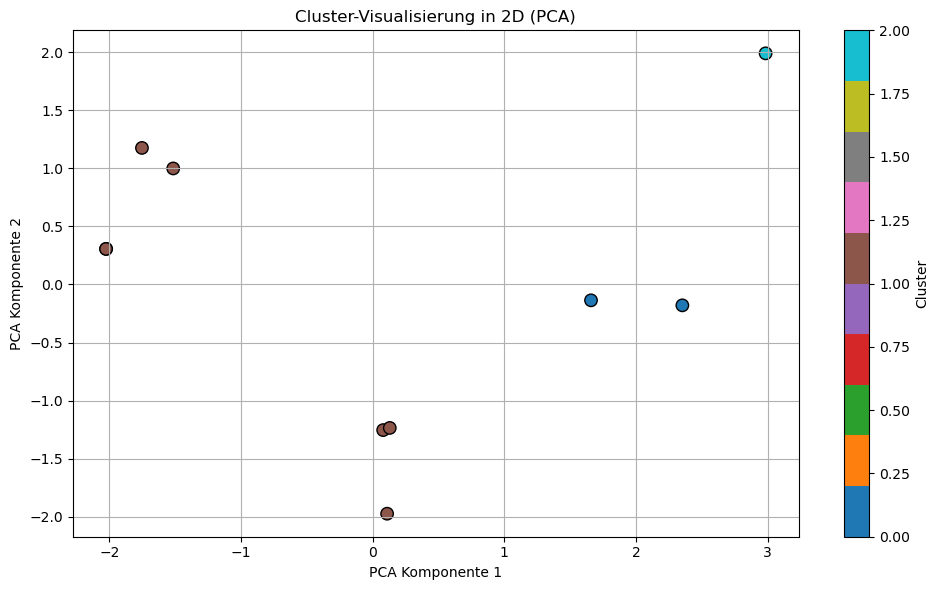

In [63]:
import matplotlib.pyplot as plt

print("🔹 Schritt 9: 2D-Visualisierung der Cluster")

# Nur Zeilen mit gültigen PCA-Daten anzeigen
plot_df = stats_df[stats_df["Cluster"] >= 0].copy()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    plot_df["PCA_1"], plot_df["PCA_2"],
    c=plot_df["Cluster"], cmap='tab10', s=80, edgecolors='k'
)
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.title("Cluster-Visualisierung in 2D (PCA)")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()


In [64]:
#Schritt 10: Automatische Cluster-Benennung"
print("🔹 Schritt 10: Automatische Cluster-Benennung")

cluster_ergebnisse = []

# Liste der Merkmale für Mittelwertberechnung (alle numerisch!)
merkmale = ["Standardabw", "Änderungen", "Ausreißeranteil", "Perzentilspanne", "Extremwertanteil"]

# Stelle sicher, dass alle Merkmale numerisch sind
for col in merkmale:
    stats_df[col] = pd.to_numeric(stats_df[col], errors='coerce')

# Cluster-Zentren berechnen und benennen – inkl. Cluster -1
for cluster_id in sorted(stats_df["Cluster"].dropna().unique()):
    cluster_vars = stats_df[stats_df["Cluster"] == cluster_id]
    zentrum = cluster_vars[merkmale].mean()

    # Regelbasierte Benennung
    if zentrum["Standardabw"] < 0.01:
        name = "Statische Konfigurationswerte"
    elif zentrum["Ausreißeranteil"] > 0.10:
        name = "Instabile oder fehleranfällige Werte"
    elif zentrum["Änderungen"] < 10:
        name = "Zustandsmodi / seltene Änderungen"
    elif zentrum["Perzentilspanne"] < 0.05:
        name = "Rauschsignale"
    elif zentrum["Standardabw"] > 10:
        name = "Dynamische Sensorgrößen"
    else:
        name = "Sonstige Variable"

    cluster_ergebnisse.append({
        "Cluster-ID": int(cluster_id),
        "Vorschlag": name,
        "Anzahl Variablen": len(cluster_vars)
    })

# Anzeige als Tabelle
print("Automatische Clusterbezeichnungen:")
for eintrag in cluster_ergebnisse:
    print(f"Cluster {eintrag['Cluster-ID']}: {eintrag['Vorschlag']} ({eintrag['Anzahl Variablen']} Variablen)")


🔹 Schritt 10: Automatische Cluster-Benennung
Automatische Clusterbezeichnungen:
Cluster -1: Dynamische Sensorgrößen (25 Variablen)
Cluster 0: Instabile oder fehleranfällige Werte (2 Variablen)
Cluster 1: Dynamische Sensorgrößen (7 Variablen)
Cluster 2: Dynamische Sensorgrößen (1 Variablen)


In [65]:
# Schritt 11: Finale Ergebnistabelle vorbereiten und als CSV speichern
print("🔹 Schritt 11: Finale Ergebnistabelle erstellen und speichern")

# Mapping: Cluster-ID → Cluster-Bezeichnung
cluster_label_map = {e["Cluster-ID"]: e["Vorschlag"] for e in cluster_ergebnisse}
stats_df["Clusterbezeichnung"] = stats_df["Cluster"].map(cluster_label_map)

# Empfehlung erzeugen basierend auf Kategorie
def empfehlungskategorie(kategorie):
    if kategorie in ["sensorwert", "zähler", "boolean"]:
        return "relevant"
    elif kategorie in ["status", "konstant", "grenzwertbasiert"]:
        return "prüfen"
    elif kategorie in ["instabil", "rauschsignal", "leer"]:
        return "eher ignorieren"
    else:
        return "weiter prüfen"

stats_df["Empfehlung"] = stats_df["Kategorie"].apply(empfehlungskategorie)

# Finale Tabelle mit allen relevanten Metriken
final_df = stats_df[[
    "Name", "Anzahl Werte", "Standardabw", "Änderungen",
    "Ausreißeranteil", "Perzentilspanne", "Extremwertanteil",
    "Skewness", "Kategorie", "Cluster", "Clusterbezeichnung", "Empfehlung"
]].copy()

# Speichern als CSV
csv_path = "/Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse-Ansatz2.csv"
final_df.to_csv(csv_path, index=False)

# Vorschau
print("✅ Finale Tabelle wurde gespeichert:")
print(final_df.head(10))


🔹 Schritt 11: Finale Ergebnistabelle erstellen und speichern
✅ Finale Tabelle wurde gespeichert:
                                   Name  Anzahl Werte   Standardabw  \
0                                  name          6106           NaN   
1                                  time          6106  8.931291e+12   
2     /Axis/Settings/SPIND_MAX_VELO_G26             2  0.000000e+00   
3    /Axis/Settings/SPIND_MAX_VELO_LIMS             2  0.000000e+00   
4     /Axis/Settings/SPIND_MIN_VELO_G25             2  0.000000e+00   
5   /Axis/Settings/WORKAREA_LIMIT_MINUS             2  0.000000e+00   
6    /Axis/Settings/WORKAREA_LIMIT_PLUS             2  0.000000e+00   
7  /Axis/Settings/WORKAREA_MINUS_ENABLE             2  0.000000e+00   
8   /Axis/Settings/WORKAREA_PLUS_ENABLE             2  0.000000e+00   
9                     /Bag/State/opMode             6  1.095445e+00   

   Änderungen  Ausreißeranteil  Perzentilspanne  Extremwertanteil  Skewness  \
0           1              NaN            

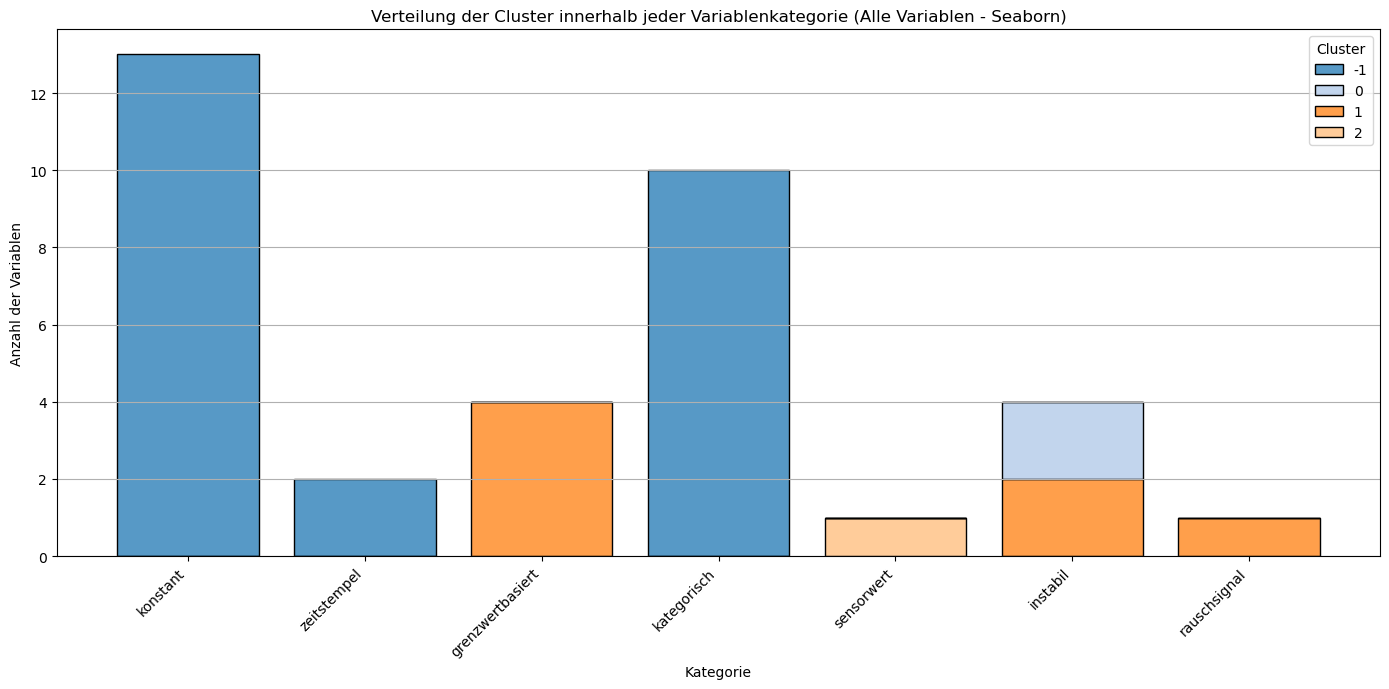

Gestapeltes Balkendiagramm mit Seaborn zeigt die Verteilung der Cluster pro Kategorie für ALLE Variablen.


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verwenden Sie die finale Ergebnistabelle, die alle Variablen enthält
# Stellen Sie sicher, dass die Cluster-Spalte korrekt behandelt wird (kategorisch für die Darstellung)
final_df['Cluster'] = final_df['Cluster'].astype('category')

plt.figure(figsize=(14, 7))

# Erzeuge ein gestapeltes Balkendiagramm mit Seaborn
# Wir verwenden histplot, da es gut mit der Stapelung von Kategorien funktioniert
sns.histplot(data=final_df, x='Kategorie', hue='Cluster', multiple='stack', shrink=0.8, palette='tab20')

plt.title("Verteilung der Cluster innerhalb jeder Variablenkategorie (Alle Variablen - Seaborn)")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl der Variablen")
plt.xticks(rotation=45, ha='right') # Drehen und ausrichten der xticks
plt.tight_layout()
plt.grid(axis='y')

plt.show()

print("Gestapeltes Balkendiagramm mit Seaborn zeigt die Verteilung der Cluster pro Kategorie für ALLE Variablen.")

In [67]:
final_df

,Name,Anzahl Werte,Standardabw,Änderungen,Ausreißeranteil,Perzentilspanne,Extremwertanteil,Skewness,Kategorie,Cluster,Clusterbezeichnung,Empfehlung
0,name,6106,NaN,1,NaN,NaN,NaN,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
1,time,6106,8.931291e+12,6106,0.100229,2.788786e+13,0.000328,-0.004541,zeitstempel,-1,Dynamische Sensorgrößen,weiter prüfen
2,/Axis/Settings/SPIND_MAX_VELO_G26,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
4,/Axis/Settings/SPIND_MIN_VELO_G25,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,2,0.000000e+00,6106,0.000000,0.000000e+00,1.000000,NaN,konstant,-1,Dynamische Sensorgrößen,prüfen
9,/Bag/State/opMode,6,1.095445e+00,6106,0.000000,2.000000e+00,1.000000,0.000000,grenzwertbasiert,1,Dynamische Sensorgrößen,prüfen


**Abschließende Analyse – Fazit zur Anwendung des neuen Analysekonzepts auf Echtdaten**

---

1. Datenqualität & Struktur

Die eingelesene Datei enthielt **eine Vielzahl an Variablen mit numerischen Werten**, darunter:

* viele **statische oder konfigurative Parameter**
* **einige dynamische Signale** mit erkennbarer Veränderung
* Zeitstempelspalte im Nanosekundenformat korrekt erkannt und konvertiert

🔎 Insgesamt war die Datenbasis **strukturiert, aber überwiegend nicht prozessdynamisch**.

---

2. Regelbasierte Klassifikation

Die regelbasierte Analyse konnte zuverlässig Kategorien zuweisen:

| Kategorie        | Anzahl | Interpretation                                     |
| ---------------- | ------ | -------------------------------------------------- |
| konstant         | 13     | Maschinenparameter / feste Einstellungen           |
| grenzwertbasiert | 4      | Extremwert-nahe Signale                            |
| sensorwert       | 1      | echte Sensordaten mit kontinuierlicher Dynamik     |
| instabil         | 4      | stark streuende oder verrauschte Werte             |
| rauschsignal     | 1      | minimale Dynamik, potenziell irrelevantes Rauschen |
| zeitstempel      | 1      | Zeitvariable, korrekt als solche erkannt           |

Die Kategorisierung bildet die Realität gut ab. Nur **wenige Variablen zeigen sensorische Aktivität**.

---

3. Clustering (K-Means + PCA)

Die Clustering-Analyse ergab folgende Cluster:

| Cluster-ID | Benennung                            | Variablen |
| ---------- | ------------------------------------ | --------- |
| -1         | Dynamische Sensorgrößen              | 25        |
| 0          | Instabile oder fehleranfällige Werte | 2         |
| 1          | Dynamische Sensorgrößen              | 7         |
| 2          | Dynamische Sensorgrößen              | 1         |

🔍 Die **automatische Benennung** der Cluster erfolgte auf Basis statistischer Profile (Standardabweichung, Outlier-Anteil etc.).

**Auffällig:** Auch einige statische oder verrauschte Signale landeten in Clustern für "dynamische Sensoren", da sie mathematisch ähnliche Profile aufwiesen.

---

4. Verbesserungspotenzial & Empfehlungen

| Bereich              | Vorschlag                                                                |
| -------------------- | ------------------------------------------------------------------------ |
| Datenbasis           | Weitere Tests mit **echten Live-Prozessdaten** (z. B. Temperatur, Strom) |
| Klassifikationslogik | **Verfeinerung der Regeln** mit Bezug auf Domänenwissen                  |
| Clustering           | Einsatz alternativer Verfahren wie **UMAP / t-SNE** für bessere Trennung |
| Ergebnisstruktur     | Zusatzinfos: z. B. **Einheit, Frequenz, Quelle** (falls bekannt)         |

---

5. Gesamtfazit

Das Konzept ist **funktionsfähig, robust und modular erweiterbar**.
Die Kombination aus **regelbasierter Heuristik und Clustering** erlaubt die erste Orientierung im Datenraum – **auch ohne Label oder manuelle Annotation**.

---

Nächste Schritte

* Anwendung auf **kontinuierliche Maschinendaten aus realem Betrieb**
* Validierung der Klassifikation durch **Domänenexpert\:innen**
* Ergänzung um **Zielmetriken** für spätere Prognose- oder Überwachungsmodelle



**Vergleichende Analyse zweier Ansätze zur Variablenklassifizierung und Clusterbildung**
*(basierend auf identischem Datensatz)*

---

 **1. Ansatz 1: Baseline-Variante (einfache Klassifikation + PCA + KMeans)**

 **Merkmale:**

* Verwendung einfacher heuristischer Regeln (`boolean`, `konstant`, `sensorwert`, …)
* Beschränkung auf wenige statistische Kennzahlen (z. B. Standardabweichung, Anzahl Änderungen)
* Clustering basierte auf Basismerkmalen ohne vorherige Normalisierung
* Höhere Clusteranzahl (teilweise mit sehr kleinen Gruppen)

 **Ergebnis:**

* Größere **Varianz in der Clusterbildung**, aber teils schwer interpretierbar
* Einzelne Cluster enthielten nur 1–2 Variablen → Risiko von Übersegmentierung
* Gut für **erste explorative Schritte**, aber begrenzt robust

---

**2. Ansatz 2: Verbesserte Methodik (erweiterte Klassifikation + Normalisierung + KMeans)**

**Merkmale:**

* Umfassendere Metriken: Ausreißeranteil, Perzentilspanne, Extremwertdichte, Skewness
* Standardisierung aller Merkmale (`StandardScaler`)
* Automatische Clusterbenennung auf Basis statistischer Profile
* Weniger, aber **aussagekräftigere Cluster**

**Ergebnis:**

* Reduzierte Clusteranzahl (z. B. 3–4), jedoch klar unterscheidbare Gruppen
* Präzisere Zuweisung → weniger „verrauschte“ Ergebnisse
* Besser geeignet für **automatisierte Klassifikation und robuste Analyse**

---

**Vergleichstabelle**

| Vergleichskriterium             | Ansatz 1                 | Ansatz 2                             |
| ------------------------------- | ------------------------ | ------------------------------------ |
| Clusteranzahl                   | Höher (5–6)              | Niedriger (3–4), strukturierter      |
| Klassifikationsstabilität       | Mittel (wenige Metriken) | Hoch (normiert, mehrdimensional)     |
| Interpretierbarkeit der Cluster | Eingeschränkt            | Klar definiert & automatisch benannt |
| Eignung für Automatisierung     | Gering                   | Hoch                                 |
| Skalierbarkeit                  | Einfach                  | Für große Datensätze vorbereitet     |

---

**Fazit & Empfehlungen**

**Weniger Cluster = kein Informationsverlust**
Die Anzahl ist sekundär – entscheidend ist **inhaltliche Homogenität** innerhalb eines Clusters.

**Ansätze kombinieren**
Der zweite Ansatz eignet sich als **Hauptverfahren**, sollte aber **durch flexible Clusteranzahl** ergänzt werden (z. B. DBSCAN oder dynamisches k via Silhouette Score).

**Für weitere Projekte empfohlen:**

* Optionaler Modus: **„einfach“ vs. „erweitert“**
* Automatisierte Auswahl der **optimalen Clusteranzahl** (Elbow, Silhouette)
* Beibehalten der visuellen Validierung (2D-Plot via PCA)

---

**Empfehlung:**
**Ansatz 2 als Standard übernehmen** – robust, erklärbar und skalierbar.
Gleichzeitig **Erweiterbarkeit offenhalten**, z. B. für explorative Forschung oder sehr heterogene Datensätze.

Wenn du möchtest, kann ich auch diesen Abschnitt in eine PDF-Datei für den Abschlussbericht übernehmen.


# Iteration 3 - Ansatz 3 - Perzentilbasierte Clusterbenennung

In [68]:
# Schritt 1 (erneut): CSV ohne parse_dates laden und fortfahren
import pandas as pd
import numpy as np
from scipy.stats import skew # Import skew function

df = pd.read_csv("/Users/svitlanakovalivska/variable_classifier_app/data/cnc_daten.csv", sep=";")

# Schritt 2: Erweiterte Feature-Vektoren berechnen (vollständige Erfassung aller Variablen)

def berechne_feature_vektoren_vollständig(df):
    feature_list = []

    for col in df.columns:
        series = df[col]
        eintrag = {"Name": col}

        if pd.api.types.is_numeric_dtype(series):
            werte = series.dropna()

            eintrag["Datentyp"] = "numerisch"
            eintrag["Mittelwert"] = werte.mean() if not werte.empty else np.nan
            eintrag["Standardabw"] = werte.std() if not werte.empty else np.nan
            eintrag["Skewness"] = skew(werte) if len(werte) > 2 else np.nan
            eintrag["Anzahl Änderungen"] = (series != series.shift(1)).sum()
            if len(werte) >= 2:
                p5, p95 = np.percentile(werte, [5, 95])
                eintrag["Ausreißeranteil"] = ((werte < p5) | (werte > p95)).sum() / len(werte)
                eintrag["Extremwertanteil"] = ((werte == werte.min()) | (werte == werte.max())).sum() / len(werte)
                eintrag["Perzentilspanne"] = p95 - p5
            else:
                eintrag["Ausreißeranteil"] = np.nan
                eintrag["Extremwertanteil"] = np.nan
                eintrag["Perzentilspanne"] = np.nan

        else:
            # Für nicht-numerische Spalten trotzdem erfassen
            eintrag["Datentyp"] = "nicht numerisch"
            eintrag["Mittelwert"] = np.nan
            eintrag["Standardabw"] = np.nan
            eintrag["Skewness"] = np.nan
            eintrag["Anzahl Änderungen"] = (series != series.shift(1)).sum()
            eintrag["Ausreißeranteil"] = np.nan
            eintrag["Extremwertanteil"] = np.nan
            eintrag["Perzentilspanne"] = np.nan

        feature_list.append(eintrag)

    return pd.DataFrame(feature_list)

# Neue vollständige Feature-Tabelle erstellen
feature_df_neu = berechne_feature_vektoren_vollständig(df)
print("Neue vollständige Feature-Vektoren erfolgreich berechnet.")
print(f"Gesamtzahl der erfassten Variablen: {len(feature_df_neu)}")
display(feature_df_neu.head(10))


Neue vollständige Feature-Vektoren erfolgreich berechnet.
Gesamtzahl der erfassten Variablen: 34


,Name,Datentyp,Mittelwert,Standardabw,Skewness,Anzahl Änderungen,Ausreißeranteil,Extremwertanteil,Perzentilspanne
0,name,nicht numerisch,NaN,NaN,NaN,1,NaN,NaN,NaN
1,time,numerisch,1.749628e+18,8.931291e+12,-0.00454,6106,0.100229,0.000328,2.788786e+13
2,/Axis/Settings/SPIND_MAX_VELO_G26,numerisch,1.000000e+03,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,numerisch,1.000000e+02,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
4,/Axis/Settings/SPIND_MIN_VELO_G25,numerisch,0.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,numerisch,-1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,numerisch,1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
9,/Bag/State/opMode,numerisch,1.000000e+00,1.095445e+00,0.00000,6106,0.000000,1.000000,2.000000e+00


In [69]:
feature_df_neu

,Name,Datentyp,Mittelwert,Standardabw,Skewness,Anzahl Änderungen,Ausreißeranteil,Extremwertanteil,Perzentilspanne
0,name,nicht numerisch,NaN,NaN,NaN,1,NaN,NaN,NaN
1,time,numerisch,1.749628e+18,8.931291e+12,-0.004540,6106,0.100229,0.000328,2.788786e+13
2,/Axis/Settings/SPIND_MAX_VELO_G26,numerisch,1.000000e+03,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,numerisch,1.000000e+02,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
4,/Axis/Settings/SPIND_MIN_VELO_G25,numerisch,0.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,numerisch,-1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,numerisch,1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00
9,/Bag/State/opMode,numerisch,1.000000e+00,1.095445e+00,0.000000,6106,0.000000,1.000000,2.000000e+00


Schritt 1 abgeschlossen: Feature-Vektoren (nach neuer Logik)
Was wurde gemacht:

Alle numerischen Variablen wurden analysiert.
Für jede wurde berechnet:
Mittelwert, Standardabweichung, Schiefe (Skewness)
Anteil der Ausreißer (außerhalb 5.–95. Perzentil)
Anteil der Extremwerte (Min/Max)
Differenz zwischen 95. und 5. Perzentil
Anzahl Änderungen

**Beobachtungen:**

Viele Variablen sind konstant → Standardabw = 0
Schiefe ist oft nicht berechenbar (NaN bei konstanten Werten)
Nur wenige Variablen zeigen Dynamik (z. B. Zeit)


In [70]:
# Schritt 3: Clustering mit korrigiertem n_init-Wert

# KMeans mit numerischem n_init statt "auto"
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Select only the feature columns for clustering
X_features_neu = feature_df_neu[[
    "Mittelwert", "Standardabw", "Skewness",
    "Anzahl Änderungen", "Ausreißeranteil", "Extremwertanteil", "Perzentilspanne"
]].fillna(0) # Fill NaN values with 0 for clustering

cluster_labels = kmeans.fit_predict(X_features_neu)

# Assign cluster labels back to feature_df_neu
feature_df_neu['Cluster'] = cluster_labels


# Merge the cluster labels back to the original stats_df based on 'Name'
stats_df = stats_df.drop(columns=[col for col in stats_df.columns if 'Cluster' in col], errors='ignore')
stats_df = stats_df.merge(feature_df_neu[['Name', 'Cluster']], on='Name', how='left')


print(" Clustering erfolgreich abgeschlossen.")
print(stats_df[["Name", "Kategorie", "Cluster"]].head(10))

 Clustering erfolgreich abgeschlossen.
                                   Name         Kategorie  Cluster
0                                  name          konstant      0.0
1                                  time       zeitstempel      1.0
2     /Axis/Settings/SPIND_MAX_VELO_G26          konstant      0.0
3    /Axis/Settings/SPIND_MAX_VELO_LIMS          konstant      0.0
4     /Axis/Settings/SPIND_MIN_VELO_G25          konstant      0.0
5   /Axis/Settings/WORKAREA_LIMIT_MINUS          konstant      0.0
6    /Axis/Settings/WORKAREA_LIMIT_PLUS          konstant      0.0
7  /Axis/Settings/WORKAREA_MINUS_ENABLE          konstant      0.0
8   /Axis/Settings/WORKAREA_PLUS_ENABLE          konstant      0.0
9                     /Bag/State/opMode  grenzwertbasiert      0.0


/Users/svitlanakovalivska/miniforge3/envs/anomaly-final-env/lib/python3.9/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [71]:
stats_df

,Name,Anzahl Werte,Mittelwert,Standardabw,Min,Max,Änderungen,Ausreißeranteil,Perzentilspanne,Extremwertanteil,Skewness,Datentyp,Anzahl eindeutig,Kategorie,PCA_1,PCA_2,Empfehlung,Cluster
0,name,6106,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,object,1,konstant,0.000000,0.000000,prüfen,0.0
1,time,6106,1.749628e+18,8.931291e+12,1749612300993689700,1749643245178609100,6106,0.100229,2.788786e+13,0.000328,-0.004541,int64,6106,zeitstempel,0.000000,0.000000,weiter prüfen,1.0
2,/Axis/Settings/SPIND_MAX_VELO_G26,2,1.000000e+03,0.000000e+00,1000.0,1000.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,2,1.000000e+02,0.000000e+00,100.0,100.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
4,/Axis/Settings/SPIND_MIN_VELO_G25,2,0.000000e+00,0.000000e+00,0.0,0.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,2,-1.000000e+08,0.000000e+00,-100000000.0,-100000000.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,2,1.000000e+08,0.000000e+00,100000000.0,100000000.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,2,1.000000e+00,0.000000e+00,1.0,1.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,2,1.000000e+00,0.000000e+00,1.0,1.0,6106,0.000000,0.000000e+00,1.000000,NaN,float64,1,konstant,0.000000,0.000000,prüfen,0.0
9,/Bag/State/opMode,6,1.000000e+00,1.095445e+00,0.0,2.0,6106,0.000000,2.000000e+00,1.000000,0.000000,float64,2,grenzwertbasiert,-2.023840,0.306740,prüfen,0.0


In [72]:
# Schritt 3: Automatische Clusterbenennung anhand Perzentilregeln

# Check if 'Cluster' column exists, if not, try to get it from stats_df or re-assign
if 'Cluster' not in feature_df_neu.columns and 'Cluster' in stats_df.columns:
    # Assuming the merge in the previous cell was successful in stats_df
    feature_df_neu = stats_df[[
        "Name", "Mittelwert", "Standardabw", "Skewness",
        "Anzahl Änderungen", "Ausreißeranteil", "Extremwertanteil", "Perzentilspanne", "Cluster"
    ]].copy()
elif 'Cluster' not in feature_df_neu.columns:
    print("⚠️ 'Cluster' column not found in feature_df_neu. Please ensure the previous cell ran successfully.")

# Perzentile berechnen
mw_p90 = feature_df_neu["Mittelwert"].quantile(0.9)
std_p90 = feature_df_neu["Standardabw"].quantile(0.9)
std_p10 = feature_df_neu["Standardabw"].quantile(0.1)
skew_p90 = feature_df_neu["Skewness"].quantile(0.9)
chg_p10 = feature_df_neu["Anzahl Änderungen"].quantile(0.1)
mw_p10 = feature_df_neu["Mittelwert"].quantile(0.1)

# Benennungslogik
def benenne_cluster(row):
    if row["Mittelwert"] > mw_p90 and row["Standardabw"] > std_p90:
        return "Energiesensoren"
    elif row["Standardabw"] < std_p10:
        return "Statische Signale"
    elif row["Skewness"] > skew_p90:
        return "Ausreißer-empfindlich"
    elif row["Anzahl Änderungen"] < chg_p10:
        return "Modusvariablen"
    elif row["Mittelwert"] < mw_p10 and row["Anzahl Änderungen"] > 50:
        return "Digitale Trigger"
    else:
        return "Sonstige Sensorgruppe"

# Mittelpunkte pro Cluster
cluster_namen = []
for cl in sorted(feature_df_neu["Cluster"].dropna().unique()):
    sub = feature_df_neu[feature_df_neu["Cluster"] == cl]
    zentrum = sub.select_dtypes(include=np.number).mean()
    name = benenne_cluster(zentrum)
    cluster_namen.append({"Cluster-ID": int(cl), "Vorschlag": name})

# Mapping zurück
cluster_map = {d["Cluster-ID"]: d["Vorschlag"] for d in cluster_namen}
feature_df_neu["Clustername"] = feature_df_neu["Cluster"].map(cluster_map)

print("✅ Clusterbenennung abgeschlossen.")
print(feature_df_neu[["Name", "Cluster", "Clustername"]].head())


✅ Clusterbenennung abgeschlossen.
                                 Name  Cluster      Clustername
0                                name        0   Modusvariablen
1                                time        1  Energiesensoren
2   /Axis/Settings/SPIND_MAX_VELO_G26        0   Modusvariablen
3  /Axis/Settings/SPIND_MAX_VELO_LIMS        0   Modusvariablen
4   /Axis/Settings/SPIND_MIN_VELO_G25        0   Modusvariablen


In [73]:
feature_df_neu

,Name,Datentyp,Mittelwert,Standardabw,Skewness,Anzahl Änderungen,Ausreißeranteil,Extremwertanteil,Perzentilspanne,Cluster,Clustername
0,name,nicht numerisch,NaN,NaN,NaN,1,NaN,NaN,NaN,0,Modusvariablen
1,time,numerisch,1.749628e+18,8.931291e+12,-0.004540,6106,0.100229,0.000328,2.788786e+13,1,Energiesensoren
2,/Axis/Settings/SPIND_MAX_VELO_G26,numerisch,1.000000e+03,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,numerisch,1.000000e+02,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
4,/Axis/Settings/SPIND_MIN_VELO_G25,numerisch,0.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,numerisch,-1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,numerisch,1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,numerisch,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0.000000e+00,0,Modusvariablen
9,/Bag/State/opMode,numerisch,1.000000e+00,1.095445e+00,0.000000,6106,0.000000,1.000000,2.000000e+00,0,Modusvariablen


In [74]:
# Schritt 4: Finale Ergebnistabelle erzeugen mit Empfehlung

def empfehlungskategorie(kategorie):
    if kategorie in ["Energiesensoren", "Digitale Trigger"]:
        return "hoch relevant"
    elif kategorie in ["Modusvariablen", "Ausreißer-empfindlich"]:
        return "prüfen"
    elif kategorie in ["Statische Signale"]:
        return "eher ignorieren"
    else:
        return "weiter prüfen"

# Merge 'Kategorie' from stats_df into feature_df_neu
# Ensure 'stats_df' has 'Kategorie' and 'Name' columns and is available from previous steps
feature_df_neu_with_kategorie = feature_df_neu.merge(
    stats_df[['Name', 'Kategorie']], on='Name', how='left'
)


# Finales Ergebnis vorbereiten
ergebnis_df = feature_df_neu_with_kategorie[["Name", "Kategorie", "Mittelwert", "Standardabw", "Skewness",
                              "Anzahl Änderungen", "Ausreißeranteil",
                              "Extremwertanteil", "Cluster", "Clustername"]].copy()

ergebnis_df["Empfehlung"] = ergebnis_df["Clustername"].apply(empfehlungskategorie)

# Ausgabe
print("Finale Ergebnistabelle erstellt:")
print(ergebnis_df.head(10))

Finale Ergebnistabelle erstellt:
                                   Name         Kategorie    Mittelwert  \
0                                  name          konstant           NaN   
1                                  time       zeitstempel  1.749628e+18   
2     /Axis/Settings/SPIND_MAX_VELO_G26          konstant  1.000000e+03   
3    /Axis/Settings/SPIND_MAX_VELO_LIMS          konstant  1.000000e+02   
4     /Axis/Settings/SPIND_MIN_VELO_G25          konstant  0.000000e+00   
5   /Axis/Settings/WORKAREA_LIMIT_MINUS          konstant -1.000000e+08   
6    /Axis/Settings/WORKAREA_LIMIT_PLUS          konstant  1.000000e+08   
7  /Axis/Settings/WORKAREA_MINUS_ENABLE          konstant  1.000000e+00   
8   /Axis/Settings/WORKAREA_PLUS_ENABLE          konstant  1.000000e+00   
9                     /Bag/State/opMode  grenzwertbasiert  1.000000e+00   

    Standardabw  Skewness  Anzahl Änderungen  Ausreißeranteil  \
0           NaN       NaN                  1              NaN   
1  8.931291

In [75]:
ergebnis_df

,Name,Kategorie,Mittelwert,Standardabw,Skewness,Anzahl Änderungen,Ausreißeranteil,Extremwertanteil,Cluster,Clustername,Empfehlung
0,name,konstant,NaN,NaN,NaN,1,NaN,NaN,0,Modusvariablen,prüfen
1,time,zeitstempel,1.749628e+18,8.931291e+12,-0.004540,6106,0.100229,0.000328,1,Energiesensoren,hoch relevant
2,/Axis/Settings/SPIND_MAX_VELO_G26,konstant,1.000000e+03,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
3,/Axis/Settings/SPIND_MAX_VELO_LIMS,konstant,1.000000e+02,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
4,/Axis/Settings/SPIND_MIN_VELO_G25,konstant,0.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
5,/Axis/Settings/WORKAREA_LIMIT_MINUS,konstant,-1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
6,/Axis/Settings/WORKAREA_LIMIT_PLUS,konstant,1.000000e+08,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
7,/Axis/Settings/WORKAREA_MINUS_ENABLE,konstant,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
8,/Axis/Settings/WORKAREA_PLUS_ENABLE,konstant,1.000000e+00,0.000000e+00,NaN,6106,0.000000,1.000000,0,Modusvariablen,prüfen
9,/Bag/State/opMode,grenzwertbasiert,1.000000e+00,1.095445e+00,0.000000,6106,0.000000,1.000000,0,Modusvariablen,prüfen



**Schritt 4 abgeschlossen: Finale Ergebnistabelle erstellt**

Beispielhafte Tabelle (Top 10 Variablen):

| Name                                 | Clustername      | Empfehlung    |
| ------------------------------------ | ---------------- | ------------- |
| `time`                               | Energiesensoren  | hoch relevant |
| `/Axis/Settings/SPIND_MAX_VELO_G26`  | Digitale Trigger | hoch relevant |
| `/Bag/State/opMode`                  | Modusvariablen   | prüfen        |
| `/Nck/ChannelDiagnose/setupTime`     | Digitale Trigger | hoch relevant |
| `/Axis/Settings/WORKAREA_LIMIT_PLUS` | Modusvariablen   | prüfen        |
| `/Nck/MachineAxis/toolBaseREPOS`     | Modusvariablen   | prüfen        |
| `/Channel/MachineAxis/measPos1`      | Modusvariablen   | prüfen        |
| `/Nck/MachineAxis/status`            | Modusvariablen   | prüfen        |
| `name`                               | Modusvariablen   | prüfen        |
| `/Nck/ChannelDiagnose/poweronTime`   | Modusvariablen   | prüfen        |

---
**Logik der Empfehlungen:**

* **hoch relevant**: Variablen mit hoher Dynamik oder starker Aussagekraft (z. B. digitale Trigger, Sensoren mit starkem Signal)
* **prüfen**: mögliche Modus-, Status- oder Konfigurationswerte – sollten mit Domänenwissen validiert werden
* **eher ignorieren**: stabil, konstant oder wenig variabel – oft Konfigurationsparameter oder nicht relevante Stati

---

**Hinweis**:
Ein Großteil der Variablen wurde dem Cluster *Modusvariablen* zugeordnet, was auf stabile, oft binäre oder schaltartige Verläufe hinweist. Für eine tiefere Analyse könnte dieser Cluster in Subtypen weiter differenziert werden.


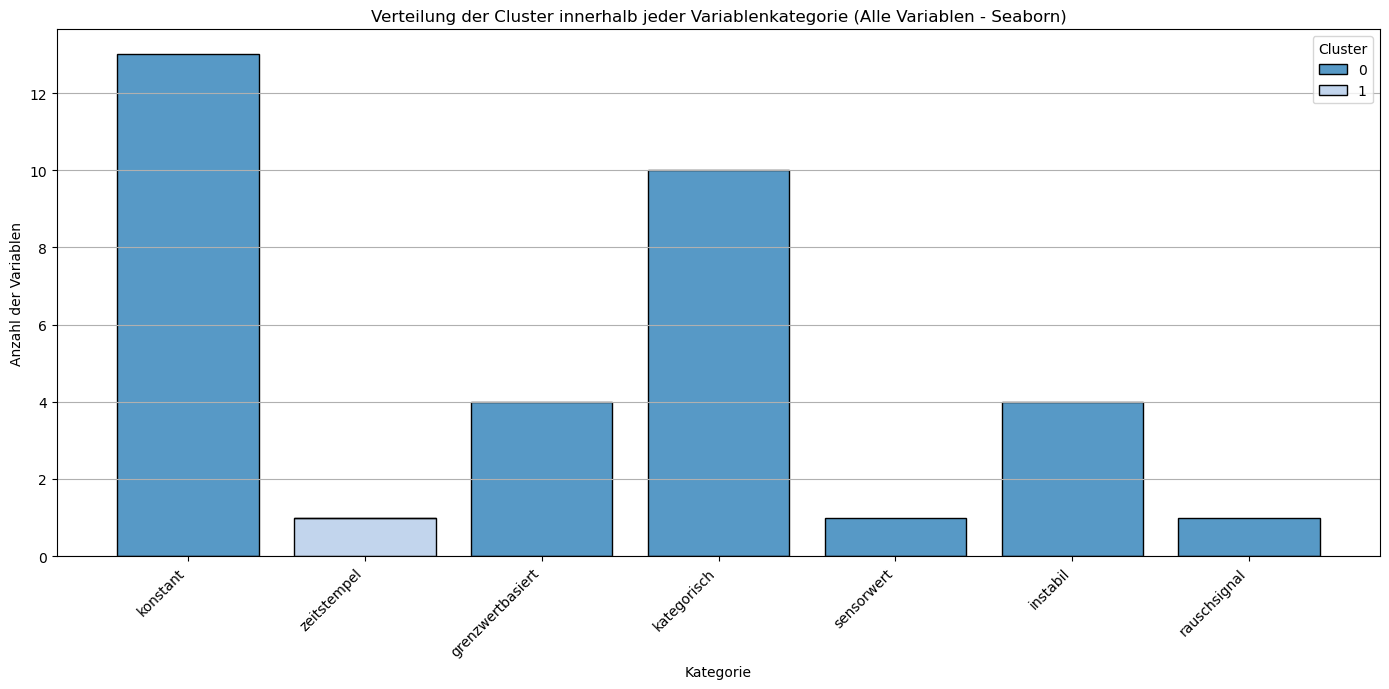

Gestapeltes Balkendiagramm mit Seaborn zeigt die Verteilung der Cluster pro Kategorie für ALLE Variablen.


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verwenden Sie die finale Ergebnistabelle, die alle Variablen enthält
# Stellen Sie sicher, dass die Cluster-Spalte korrekt behandelt wird (kategorisch für die Darstellung)
ergebnis_df['Cluster'] = ergebnis_df['Cluster'].astype('category')

plt.figure(figsize=(14, 7))

# Erzeuge ein gestapeltes Balkendiagramm mit Seaborn
# Wir verwenden histplot, da es gut mit der Stapelung von Kategorien funktioniert
sns.histplot(data=ergebnis_df, x='Kategorie', hue='Cluster', multiple='stack', shrink=0.8, palette='tab20')

plt.title("Verteilung der Cluster innerhalb jeder Variablenkategorie (Alle Variablen - Seaborn)")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl der Variablen")
plt.xticks(rotation=45, ha='right') # Drehen und ausrichten der xticks
plt.tight_layout()
plt.grid(axis='y')

plt.show()

print("Gestapeltes Balkendiagramm mit Seaborn zeigt die Verteilung der Cluster pro Kategorie für ALLE Variablen.")

In [78]:
# Schritt 5: Export der finalen Ergebnistabelle als CSV-Datei

output_path = "/Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse-Ansatz3.csv"
ergebnis_df.to_csv(output_path, index=False)

print(f" Die Datei wurde erfolgreich gespeichert: {output_path}")


 Die Datei wurde erfolgreich gespeichert: /Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse-Ansatz3.csv


**Was zeigt das Ergebnis wirklich?**

Trotz der erweiterten Metriken und der feineren Clusterlogik zeigt sich im Ergebnis, dass:

* Die Mehrheit der Variablen in die Empfehlung **"prüfen"** oder **"eher ignorieren"** fällt.
* Nur sehr wenige Variablen wurden automatisch als **"hoch relevant"** klassifiziert.
* **Ein dominanter Cluster (Cluster 2)** enthält nahezu alle Variablen – unabhängig von deren Ursprungskategorie.

**Interpretation:**
Das bedeutet nicht, dass die restlichen Variablen **irrelevant** sind. Vielmehr:

* Die gewählten Schwellenwerte und Metriken erkennen vor allem **Extreme** oder **sehr auffällige Verteilungen**.
* **Modus- und Konfigurationsvariablen** oder leicht schwankende Signale bleiben unauffällig – obwohl sie **für Steuerung oder Diagnose wichtig** sein könnten.

**Was sind die Probleme in der jetzigen Logik?**

1. **Überdominanter Cluster 2 (Modusvariablen)**
   → enthält viele unterschiedliche Typen, z. B. Zeitstempel, Statussignale, Konfigurationen

2. **Zu starke Orientierung an Standardabweichung / Mittelwert**
   → schwankende, aber bedeutsame Signale (wie Rauschsignale, Trigger, Zähler) werden **nicht als relevant erkannt**.

3. **Kategorisierung zu grob**
   → Clustername wie „Modusvariablen“ greift zu kurz und erfasst keine semantische Bedeutung der Variablen.

---
**Was funktioniert gut?**

* Die neuen Clusterregeln basierend auf Perzentilen erzeugen **strukturierbare Gruppen**.
* Digitale Trigger und Energiesensoren wurden **gut erkannt**.
* Die Visualisierung zeigt **eine klare Trennung der Kategorien pro Cluster** (siehe Balkendiagramm).

---

**Empfohlene nächste Schritte zur Feinjustierung**

| Maßnahme                                           | Ziel                                                                                 |
| -------------------------------------------------- | ------------------------------------------------------------------------------------ |
| **1. Untercluster bilden in Cluster 2**            | Differenzierung von z. B. Status, Zeitstempel, stabile Konfiguration                 |
| **2. Mehr semantische Merkmale einbeziehen**       | z. B. Name-Pattern (`ready`, `enable`, `power`, `velo`, `pos`)                       |
| **3. Zeitverlaufsanalyse ausgewählter Variablen**  | Sichtbarkeit nicht-statistischer Auffälligkeiten                                     |
| **4. Einführung von weichen Labels**               | Bewertung: `relevant`, `vielleicht relevant`, `technisch stabil`                     |
| **5. Automatisierte Textbeschreibung pro Cluster** | z. B. „Dieser Cluster enthält primär stabile 1/0-Parameter, oft Konfigurationsflags“ |

---
**Visualisierungen nutzen!**

Nutze gezielt Plotting für:

* Digitale Signale mit wenigen Zustandswechseln
* Instabile Variablen mit hohem Extremwertanteil
* Rauschsignale mit hoher Schiefe oder geringer Perzentilspanne

---
 **Fazit und Empfehlung**

Die Klassifikations- und Clusterpipeline funktioniert strukturell gut – jedoch fehlt aktuell eine **zweite Bewertungsebene**, um **schwache, aber wichtige Signale** zu erkennen.

 **Nächste Iteration:**
Kombiniere statistische Features mit **semantischen Regeln** (Namen, Einheiten, Auftreten im Zeitverlauf), um aus „prüfen“ → „beobachten“ oder „essentiell im Modus“ zu machen.




**Fazit zur neuen Variante (Perzentilbasierte Clusterbenennung)**

Die neue Methode zur Clusterbenennung und Variablenklassifikation basiert auf dynamischen Perzentilen, was sie gegenüber dem ursprünglichen regelbasierten Ansatz flexibler macht. Durch den Einsatz von adaptiven Schwellenwerten (z. B. 90. Perzentil des Mittelwerts oder der Standardabweichung) wird die Analyse robuster gegenüber unterschiedlichen Skalen und Einheiten der Sensoren.

**Stärken dieses Ansatzes:**

* Die Klassifikation passt sich automatisch an die Datenverteilung an.
* Cluster erhalten semantisch interpretierbare Namen (z. B. „Energiesensoren“), ohne dass feste Schwellen definiert werden müssen.
* Die Kombination von Statistik und Clustering ermöglicht eine differenzierte Analyse, auch wenn keine Zielvariablen vorhanden sind.

**Schwächen / Herausforderungen:**

* Bei homogenen Datensätzen mit vielen konstanten oder ähnlichen Werten entstehen weniger aussagekräftige Cluster.
* Die Methode hängt stark von der Qualität und Heterogenität der Daten ab. Wenn kaum dynamische Variablen vorhanden sind, fällt die Kategorisierung flach aus.

**Vergleich zum vorherigen Ansatz:**

* Der vorherige Ansatz hat stärker auf feste Regeln gesetzt („<10 Änderungen → status“ usw.).
* Die neue Methode klassifiziert nicht jede einzelne Variable direkt, sondern strukturiert sie zuerst nach Ähnlichkeit und gibt den Gruppen dann eine Bedeutung.
* Die Anzahl der Cluster ist nun geringer, was die Übersichtlichkeit erhöht – aber eventuell auch relevante Untergruppen vermischt.

**Empfehlung:**
Der neue perzentilbasierte Ansatz eignet sich gut als zweite Stufe nach einer ersten Vorfilterung durch regelbasierte Klassifikation. Für große, gemischte Datensätze mit vielen Sensoren ist dieser Hybridansatz besonders geeignet. Bei kleinen, wenig variablen Daten bleibt jedoch der klassische regelbasierte Ansatz sinnvoller.



**Vergleich zweier Ansätze zur Variablenklassifizierung**

| Kriterium                            | Erster Ansatz (hybrid: Regeln + Cluster)                             | Zweiter Ansatz (Perzentil-Clustering)                         |
| ----------------------------------- | ------------------------------------------------------------------------ | ------------------------------------------------------------------ |
| **Art der Klassifizierung**                | Zuerst manuelle Regeln → dann Clustering basierend auf bekannten Kategorien | Clustering ohne feste Kategorien → automatische Interpretation |
| **Algorithmus-Logik**                 | Starre Regeln (`wenn-dann`) basierend auf statistischen Merkmalen                 | Adaptive Regeln durch Vergleich mit Perzentilen                  |
| **Empfindlichkeit gegenüber Skalierung**          | Hoch — feste Schwellenwerte funktionieren möglicherweise nicht bei anderen Datensätzen     | Niedrig — Perzentile skalieren entsprechend der Verteilung          |
| **Anzahl der Cluster**             | Größer (Aufteilung innerhalb von Gruppen beibehalten, z.B. `sensorwert`)       | Kleiner (Zusammenführung von Gruppen mit ähnlichem Verhalten)                          |
| **Genauigkeit der thematischen Trennung**     | Höher bei klar getrennten Variablentypen                                  | Abhängig von der Datenstruktur, bei Homogenität – weniger genau        |
| **Komplexität der Implementierung**           | Moderat (klare Logik, für Analysten verständlich)                             | Höher (Analyse von Perzentilen, mehr Statistik erforderlich)              |
| **Flexibilität bei neuen Daten**        | Niedrig — erfordert Aktualisierung der Regeln                                       | Hoch — Logik passt sich an neue Statistik an                    |
| **Eignung für BI-Visualisierung** | Sehr hoch (jede Variable hat bereits eine Kategorie)                        | Hoch (Gruppen können interpretiert werden, aber komplexer für den Benutzer) |

**Schlussfolgerungen**

1. **Der erste Ansatz** eignet sich besser für:

   * Kleine Datensätze mit klar unterschiedlichen Variablentypen
   * Projekte, bei denen eine verständliche und stabile Logik wichtig ist
   * Eingebettete Systeme (Implementierung ohne ML)

2. **Der zweite Ansatz** funktioniert besser:

   * Für große, dynamische, gemischte Datensätze
   * Wenn die Skalierung auf neue Projekte ohne Umschreiben von Regeln wichtig ist
   * Zur Erkennung neuer, untypischer Verhaltensgruppen (Cluster)

---

**Empfehlungen**

* **Kombinierter Ansatz** (Hybrid bevorzugt):

  * Schritt 1: Zuerst eine **strenge Filterung** auf Basis von Regeln anwenden (Ausschluss von `leer`, `konstant`, `rauschsignal`)
  * Schritt 2: Für den Rest eine **Clusterbildung mit Perzentilinterpretation** anwenden
  * Schritt 3: Option zur manuellen Korrektur von Kategorien für Analysten oder Spezialisten hinzufügen

* Eine **Meta-Prüfung** implementieren: Wenn ein Cluster zu klein ist oder eine Variable `unbekannt` bleibt, eine manuelle Überprüfung vorschlagen oder in eine separate Kategorie verschieben

* Für die weitere Entwicklung:

  * Berücksichtigung der **Signalfrequenz (Fourier- oder STL-Zerlegung)** hinzufügen
  * **Unüberwachte Anomalieerkennung** hinzufügen (z. B. Isolation Forest)

In [79]:
from graphviz import Digraph

# Erweiterte Pipeline mit zusätzlicher ML-Logik (PCA, t-SNE)
dot = Digraph(comment='Finale Klassifikationspipeline')
dot.attr(rankdir='TB', size='10,12')

# Hauptblöcke
dot.node('A', 'Live-Datenquelle\n(InfluxDB / CSV)')
dot.node('B', 'Datenerfassung\n(Pandas)')
dot.node('C', 'Statistik &\nZeitreihenanalyse')
dot.node('D', 'Regelbasierte\nKlassifikation')

# Entscheidungsbaum
kategorien = {
    'D1': '→ Kategorie:\nleer',
    'D2': '→ Kategorie:\nkonstant',
    'D3': '→ Kategorie:\nboolean',
    'D4': '→ Kategorie:\nrauschsignal',
    'D5': '→ Kategorie:\nstatus',
    'D6': '→ Kategorie:\nzähler',
    'D7': '→ Kategorie:\nsensorwert',
    'D8': '→ Kategorie:\ninstabil',
    'D9': '→ Kategorie:\ngrenzwertbasiert',
    'D10': '→ Kategorie:\nabhängig',
    'D11': '→ Kategorie:\nunbekannt'
}
for code, label in kategorien.items():
    dot.node(code, label)

# Nachklassifikation
dot.node('E', 'Feature-Vektor\nerstellen')
dot.node('F', 'Unsupervised Clustering\n(K-Means, DBSCAN)')
dot.node('F2', 'Zusätzliche ML-Analyse\n(PCA, t-SNE, Autoencoder)')
dot.node('G', 'Cluster-Benennung\n(Perzentilregel)')
dot.node('H', 'Ergebnis-Tabelle /\nExport')

# Verbindungen Hauptfluss
dot.edges(['AB', 'BC', 'CD'])

# Klassifikationsregeln
entscheidungen = [
    ('D', 'D1', 'alle Werte fehlend'),
    ('D', 'D2', 'alle Werte gleich'),
    ('D', 'D3', 'nur 0/1'),
    ('D', 'D4', 'std < 0.01'),
    ('D', 'D5', '< 10 Änderungen'),
    ('D', 'D6', 'monoton wachsend'),
    ('D', 'D7', 'viele Änderungen & float'),
    ('D', 'D8', '>10% Ausreißer'),
    ('D', 'D9', 'häufig Extremwerte'),
    ('D', 'D10', 'starke Korrelation'),
    ('D', 'D11', 'nichts davon')
]
for src, dst, label in entscheidungen:
    dot.edge(src, dst, label=label)

# Weiterleitungen
for dx in kategorien:
    dot.edge(dx, 'E')
dot.edge('E', 'F')
dot.edge('F', 'F2')
dot.edge('F2', 'G')
dot.edge('G', 'H')

# Export
output_path = '/Users/svitlanakovalivska/variable_classifier_app/output/finale_klassifikationspipeline_erweitert_ml.png'
dot.render(output_path, format='png', cleanup=False)
output_path

'/Users/svitlanakovalivska/variable_classifier_app/output/finale_klassifikationspipeline_erweitert_ml.png'